
# EDA: PIB por Países y Regiones 



1. Entorno y Configuración
2. Carga de Datos y Visión General
3. Diccionario de Datos
4. Limpieza y Preparación
5. Análisis Univariante
6. Análisis Bivariante
7. Análisis Multivariante
8. Correlaciones y Visualizaciones
9. Tests de Hipótesis
10. Conclusiones y Próximos Pasos
11. Anexos y Presentación

CSV A UTILIZAR: "https://databank.worldbank.org/data/download/WDI_CSV.zip"

In [ ]:
####################################################################################################################O.o

INDICA CODIGOS DE APOYO Y PIPELINES EN CASO DE FALLOS DE VISUALIZACIONES, CODIGOS COMPLETOS AL FINAL DEL DOC EN ANEXOS

* (Ejecuta en 1 solsa celda para mejorar visuals)

Producto Interno Bruto (PIB) es el valor monetario de todos los bienes y servicios finales producidos dentro de las fronteras de un país durante un período determinado, generalmente un año

Producto Interno Bruto (PIB) de un país dividido por su población total, y representa la riqueza promedio generada por cada habitante.



TRADUCCIÓN PIB = GDP


## 0. Hipótesis (definidas antes de mirar los datos)
H0: Análisis univariante- PIB N y PIB Pc

H1: Visualización por Regiones

H2: Análisis Bivariante PIB Nominal vs PIB Per Cápita: ¿se correlacionan?

H3: Análisis multivariante: PIB N vs Resto de Vars Económicas: sino,¿que valores económicos si se correlacionan?
 



##  Configuracion y carga de datos
Cargamos el CSV, detectamos columnas clave de forma flexible y preparamos el DataFrame.  
Vista rápida de columnas, forma y primeras filas.


In [ ]:

PATH = r"C:\Users\Asus Vivobook\Downloads\world_bank_dataset.csv.csv"

import pandas as pd, numpy as np, matplotlib.pyplot as plt, unicodedata, re
plt.rcParams["figure.figsize"] = (10, 6)

# Carga robusta
try:
    df = pd.read_csv(PATH)
except UnicodeDecodeError:
    df = pd.read_csv(PATH, encoding="latin-1")

print("Columnas detectadas:", list(df.columns))
print("Forma:", df.shape)
display(df.head(3))


Columnas detectadas: ['country', 'country_code', 'year', 'gdp_usd', 'population', 'life_expectancy', 'unemployment_rate', 'co2_pc', 'electricity_access']
Forma: (17195, 9)


,country,country_code,year,gdp_usd,population,life_expectancy,unemployment_rate,co2_pc,electricity_access
0,Afghanistan,AFG,1960,NaN,9035043.0,32.799,NaN,NaN,NaN
1,Afghanistan,AFG,1961,NaN,9214083.0,33.291,NaN,NaN,NaN
2,Afghanistan,AFG,1962,NaN,9404406.0,33.757,NaN,NaN,NaN



## Deteccion de columnas / tipin
Normalizamos nombres, localizamos Año/País/ISO3/PIB/Población/Región y convertimos a numérico cuando toca.  
Variables clave listas y reporte de mapeo.


In [ ]:
def norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^A-Za-z0-9]+", "", s).lower()
    return s

N = {norm(c): c for c in df.columns}

def pick(cands):
    for c in cands:
        if c in N: return N[c]
    return None

col_year    = pick(["year","año","anio","ano"])
col_country = pick(["country","pais","país","tablename","shortname","countryname","name"])
col_iso3    = pick(["countrycode","country_code","codigopais","códigopaís","iso3code","iso3","code"])
col_gdp     = pick(["gdpusd","pibusd","gdp","nygdpmktpcd","gdpcurrentusd","gdpcurrentus"])
col_pop     = pick(["population","poblacion","población","sppoptotl","pop"])
col_life    = pick(["lifeexpectancy","esperanzavida","spdyncle00in"])
col_unemp   = pick(["unemployment_rate","tasadesempleo","sluemtotlzs"])
col_elec    = pick(["electricity_access","acceso_electricidad","egelcaccszs"])
col_region  = pick(["region","región"])

In [ ]:
# Tipin para entenderlo
for c in [col_year, col_gdp, col_pop, col_life, col_unemp, col_elec]:
    if c and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print(" columnas tipe ")
print("  Año:", col_year)
print("  País:", col_country)
print("  ISO3:", col_iso3)
print("  PIB:", col_gdp)
print("  Población:", col_pop)
print("  Esperanza de vida:", col_life)
print("  Desempleo:", col_unemp)
print("  Electricidad:", col_elec)
print("  Región:", col_region)


 columnas tipe 
  Año: year
  País: country
  ISO3: country_code
  PIB: gdp_usd
  Población: population
  Esperanza de vida: life_expectancy
  Desempleo: None
  Electricidad: None
  Región: None


In [ ]:
#detección de columna
def guess_col(df, candidates_exact=set(), candidates_partial=()):
    cols = list(df.columns)
    low = {c: c.lower() for c in cols}
    for c in cols:
        if low[c] in candidates_exact:
            return c
    for c in cols:
        if any(p in low[c] for p in candidates_partial):
            return c
    return None

col_country = 'country' if 'country' in df.columns else guess_col(
    df, {'country','pais','país','economy','country_name','countryname'},
    ('country','pais','país','economy','name')
)
col_year    = 'year' if 'year' in df.columns else guess_col(
    df, {'year','año','anio','period','periodo'},
    ('year','año','anio','period','fecha')
)
col_gdp     = 'gdp_usd' if 'gdp_usd' in df.columns else guess_col(
    df, {'gdp','gdp_usd','pib','pib_usd','ngdp','gdp_current_usd','value'},
    ('gdp','pib','current','usd','ngdp','value')
)
col_pop     = guess_col(df, {'population','pop','sp.pop.totl'}, ('population','poblac','pop','sp.pop'))
col_region  = guess_col(df, {'region','región','area','zona','income_group','income level'}, ('region','región','area','zona','income','ingreso'))
col_unemp   = guess_col(df, {'unemployment','unemp','unemp_rate'}, ('unemp','paro','desemple','unemployment'))
col_elec    = guess_col(df, {'electricity_access','elec_access','access_electricity'}, ('electric','elec','electricity','acceso'))
col_life    = guess_col(df, {'life_expectancy','lifeexp','le','sp.dyn.le00.in'}, ('life','expectancy','esperanza','le00'))

print("Columnas:")
print(" - country:", col_country)
print(" - year   :", col_year)
print(" - gdp    :", col_gdp)
print(" - pop    :", col_pop)
print(" - region :", col_region)
print(" - unemp  :", col_unemp)
print(" - elec   :", col_elec)
print(" - life   :", col_life)

# - PIB per cápita 
# - Crecimiento  por país
# - Serie Temporal CAGR 5 años 

In [ ]:

if col_gdp and col_pop and col_pop in df.columns:
    df["gdp_pc"] = np.where((df[col_gdp] > 0) & (df[col_pop] > 0), df[col_gdp] / df[col_pop], np.nan)
else:
    df["gdp_pc"] = np.nan

if col_year and col_country and col_gdp:
    df = df.sort_values([col_country, col_year])
    df["gdp_growth"] = df.groupby(col_country, sort=False)[col_gdp].pct_change()

def cagr_window(group, years=5):
    g = group.sort_values(col_year)
    vals = g[[col_year, col_gdp]].dropna()
    vals = vals[vals[col_gdp] > 0]
    out = pd.Series(index=g.index, dtype=float)
    if vals.empty: 
        return out
 
    m = dict(zip(vals[col_year].astype(int), vals[col_gdp]))
    for i, (idx, row) in enumerate(g.iterrows()):
        yr = int(row[col_year]) if pd.notna(row[col_year]) else None
        if yr is None or yr not in m: 
            continue
        start = yr - years
        if start in m and m[start] > 0:
            out.loc[idx] = (m[yr] / m[start])**(1/years) - 1
    return out

if col_year and col_country and col_gdp:
    df["cagr_5y"] = df.groupby(col_country, group_keys=False, sort=False).apply(cagr_window, years=5)

print(df[[col_country, col_year, col_gdp, "gdp_pc", "gdp_growth", "cagr_5y"]].head(8))


Columnas:
 - country: country
 - year   : year
 - gdp    : gdp_usd
 - pop    : population
 - region : Region
 - unemp  : unemployment_rate
 - elec   : electricity_access
 - life   : life_expectancy


C:\Users\Asus Vivobook\AppData\Local\Temp\ipykernel_30228\2358367226.py:77: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["gdp_growth"] = df.groupby(col_country, sort=False)[col_gdp].pct_change()


       country  year  gdp_usd  gdp_pc  gdp_growth  cagr_5y
0  Afghanistan  1960      NaN     NaN         NaN      NaN
1  Afghanistan  1961      NaN     NaN         NaN      NaN
2  Afghanistan  1962      NaN     NaN         NaN      NaN
3  Afghanistan  1963      NaN     NaN         NaN      NaN
4  Afghanistan  1964      NaN     NaN         NaN      NaN
5  Afghanistan  1965      NaN     NaN         NaN      NaN
6  Afghanistan  1966      NaN     NaN         NaN      NaN
7  Afghanistan  1967      NaN     NaN         NaN      NaN


C:\Users\Asus Vivobook\AppData\Local\Temp\ipykernel_30228\2358367226.py:98: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["cagr_5y"] = df.groupby(col_country, group_keys=False, sort=False).apply(cagr_window, years=5)



## 3. Región 
Si no existe columna de **región**, la mapeamos desde los metadatos del Banco Mundial.  
Columna de región en `df` y exclusión de agregados.


In [ ]:
if col_region is None:
    import io, zipfile, requests
    WDI_ZIP_URL = "https://databank.worldbank.org/data/download/WDI_CSV.zip"
    r = requests.get(WDI_ZIP_URL, timeout=120); r.raise_for_status()
    z = zipfile.ZipFile(io.BytesIO(r.content))
    cand = [n for n in z.namelist() if n.lower().endswith("wdicountry.csv")]
    meta = pd.read_csv(z.open(cand[0]), encoding="latin-1")

    M = {norm(c): c for c in meta.columns}
    m_code   = M.get("countrycode") or M.get("code") or M.get("iso3code") or M.get("iso3")
    m_region = M.get("region") or M.get("región")
    m_name   = M.get("tablename") or M.get("shortname") or M.get("countryname") or M.get("name")

    if col_iso3 and m_code:
        df = df.merge(meta[[m_code, m_region]], left_on=col_iso3, right_on=m_code, how="left")
        col_region = m_region
    elif col_country and m_name:
        df["_nc"] = df[col_country].astype(str).map(norm)
        meta["_nc"] = meta[m_name].astype(str).map(norm)
        df = df.merge(meta[["_nc", m_region]], on="_nc", how="left").drop(columns=["_nc"])
        col_region = m_region
    else:
        print("Aviso: no ,falta ISO3 o nombre.")


,country,country_code,Region
0,Afghanistan,AFG,Middle East & North Africa
1,Afghanistan,AFG,Middle East & North Africa
2,Afghanistan,AFG,Middle East & North Africa
3,Afghanistan,AFG,Middle East & North Africa
4,Afghanistan,AFG,Middle East & North Africa


In [ ]:
# COMPILAMOS
AGG_PATTERNS = re.compile(
    r"(world|income|oecd|ibrd|ida|euro area|europe|asia|africa|america|"
    r"pacific|caribbean|arab|middle east|emerging|g20|g7|"
    r"high|upper|lower|low|middle)\b", re.I
)

def looks_aggregate(name:str)->bool:
    n = str(name).strip()
    if not n: 
        return True
    if n in AGGREGATE_NAMES:  # si tenemos lista online
        return True
    return bool(AGG_PATTERNS.search(n))

In [ ]:

def solo_paises(df, col_nombre=col_nombre, col_valor=col_valor, col_iso3=col_iso3):
    df = df.copy()
    if col_valor in df.columns:
        df[col_valor] = df[col_valor].map(to_number_usd)

    if col_iso3 and col_iso3 in df.columns and COUNTRY_CODES:
        mask = df[col_iso3].isin(COUNTRY_CODES)
    elif COUNTRY_NAMES:
        mask = df[col_nombre].isin(COUNTRY_NAMES)
    else:
     ##
        mask = ~df[col_nombre].map(looks_aggregate)   #Se conecta offline(COMP)

    out = df.loc[mask, [col_nombre] + ([col_iso3] if col_iso3 else []) + [col_valor]]
    return out.dropna(subset=[col_valor])

def top10_pib(df, col_nombre=col_nombre, col_valor=col_valor, col_iso3=col_iso3):
    paises = solo_paises(df, col_nombre, col_valor, col_iso3)
    top = paises.sort_values(col_valor, ascending=False).head(10).copy()
    top["PIB_formateado"] = top[col_valor].apply(lambda v: f"${v:,.0f} ({v/1e12:.2f} T)")
    cols = [col_nombre] + ([col_iso3] if col_iso3 else []) + ["PIB_formateado"]
    return top[cols].reset_index(drop=True)

Columnas(Col)

In [ ]:
col_nombre = "Pais/Grupo"
col_valor  = "PIB_USD"
col_iso3   = None  #  ISO3?

In [ ]:

df = pd.DataFrame({
    "Pais/Grupo": ["World","United States","China","OECD members","India","European Union","Japan","High income","Germany","France","Italy","United Kingdom"],
    "PIB_USD": ["$111,252,997,846,886","$30,615,743,000,000","$19,398,577,000,000","$67,687,054,565,878","$4,125,213,000,000",
                "$18,000,000,000,000","$4,279,828,000,000","$71,522,995,943,824",
                "$5,013,574,000,000","$3,361,557,000,000","$2,543,677,000,000","$3,958,780,000,000"]
})

top10 = top10_pib(df, col_nombre=col_nombre, col_valor=col_valor, col_iso3=col_iso3)


try:
    display(top10)  
except NameError:
    print(top10)    


,Pais/Grupo,PIB_formateado
0,World,"$111,252,997,846,886 (111.25 T)"
1,High income,"$71,522,995,943,824 (71.52 T)"
2,OECD members,"$67,687,054,565,878 (67.69 T)"
3,United States,"$30,615,743,000,000 (30.62 T)"
4,China,"$19,398,577,000,000 (19.40 T)"
5,European Union,"$18,000,000,000,000 (18.00 T)"
6,Germany,"$5,013,574,000,000 (5.01 T)"
7,Japan,"$4,279,828,000,000 (4.28 T)"
8,India,"$4,125,213,000,000 (4.13 T)"
9,United Kingdom,"$3,958,780,000,000 (3.96 T)"


Tranformamos la escala log del eje X (sin transformar datos) para mejorar su visuaLización de distribuciones


## 4. Calidad de datos
Revisión de nulos, tipos y rango temporal.  
Reporte de nulos top, dtypes y rango de años.


In [ ]:

print("Nulos por columna (top 15):")
display(df.isna().sum().sort_values(ascending=False).head(15))

print("\nTipos:")
display(df.dtypes)

if col_year:
    try:
        print("\nRango de años:", int(df[col_year].min()), "a", int(df[col_year].max()))
    except Exception:
        pass


Nulos por columna (top 15):


co2_pc                14075
unemployment_rate      7726
electricity_access     7543
cagr_5y                3597
gdp_growth             2650
gdp_usd                2526
gdp_pc                 2526
life_expectancy         221
country                   0
country_code              0
population                0
year                      0
Country Code              0
Region                    0
dtype: int64


Tipos:


country                object
country_code           object
year                    int64
gdp_usd               float64
population            float64
life_expectancy       float64
unemployment_rate     float64
co2_pc                float64
electricity_access    float64
gdp_pc                float64
gdp_growth            float64
cagr_5y               float64
Country Code           object
Region                 object
dtype: object


Rango de años: 1960 → 2024



##SERIE TEMPORAL 5 AÑOS PIB
Creamos **PIB per cápita**, **crecimiento interanual** y **CAGR 5 años**.  
Nuevas columnas `gdp_pc`, `gdp_growth`, `cagr_5y`.


# PIB per capita habitante

In [ ]:


if col_gdp and col_pop:
    df["gdp_pc"] = df[col_gdp] / df[col_pop]
else:
    df["gdp_pc"] = np.nan

# Crecimiento interanual x país

In [ ]:

if col_year and col_country and col_gdp:
    df = df.sort_values([col_country, col_year])
    df["gdp_growth"] = df.groupby(col_country)[col_gdp].pct_change()

# CAGR serie temporal:5 años

In [ ]:

def cagr_window(group, years=5):
    g = group.sort_values(col_year).set_index(col_year)[col_gdp].dropna()
    out = pd.Series(index=group.index, dtype=float)
    for yr in g.index:
        start = yr - years
        if (start in g.index) and (g.loc[start] > 0):
            out.loc[group.index[group[col_year] == yr]] = (g.loc[yr]/g.loc[start])**(1/years) - 1
    return out

if col_year and col_country and col_gdp:
    df["cagr_5y"] = df.groupby(col_country, group_keys=False).apply(cagr_window, years=5)

display(df[[c for c in [col_country, col_year, col_gdp, 'gdp_pc', 'gdp_growth', 'cagr_5y'] if c in df.columns]].head(8))


C:\Users\Asus Vivobook\AppData\Local\Temp\ipykernel_30228\3340789944.py:10: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["gdp_growth"] = df.groupby(col_country)[col_gdp].pct_change()
C:\Users\Asus Vivobook\AppData\Local\Temp\ipykernel_30228\3340789944.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["cagr_5y"] = df.groupby(col_country, group_keys=False).apply(cagr_window, years=5)


,country,year,gdp_usd,gdp_pc,gdp_growth,cagr_5y
0,Afghanistan,1960,NaN,NaN,NaN,NaN
1,Afghanistan,1961,NaN,NaN,NaN,NaN
2,Afghanistan,1962,NaN,NaN,NaN,NaN
3,Afghanistan,1963,NaN,NaN,NaN,NaN
4,Afghanistan,1964,NaN,NaN,NaN,NaN
5,Afghanistan,1965,NaN,NaN,NaN,NaN
6,Afghanistan,1966,NaN,NaN,NaN,NaN
7,Afghanistan,1967,NaN,NaN,NaN,NaN


#CODIGO AGREGADO PARA AYUDAR A LA NORMALIZACIÓN

In [ ]:
####################################################################################################################O.o
def normalize(s: str) -> str:
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))  # quita acentos
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "", s)  # quita espacios y símbolos
    return s

####################################################################################################################O.o

PIB EN USD

Columnas detectadas en el CSV:
['country', 'country_code', 'year', 'gdp_usd', 'population', 'life_expectancy', 'unemployment_rate', 'co2_pc', 'electricity_access']
Usando columna detectada para PIB: gdp_usd


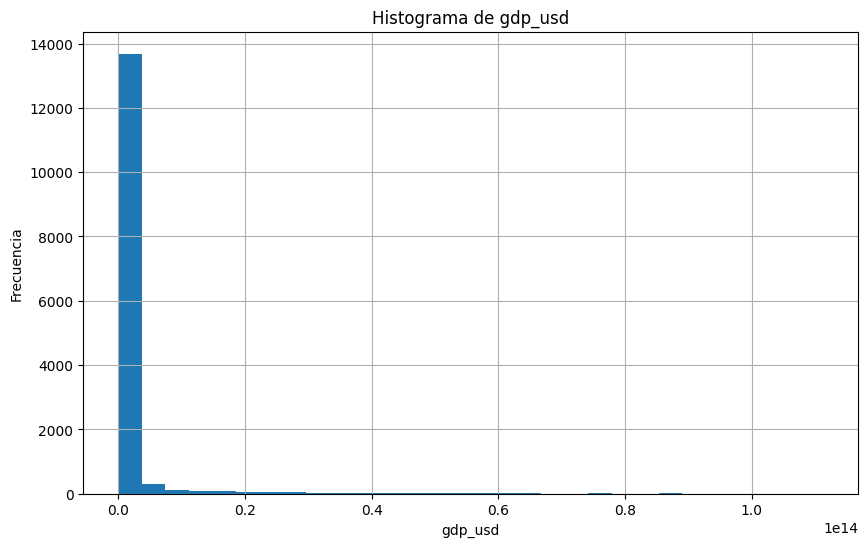

In [ ]:
#cols
aliases = [
    "pib_usd", "pibusd", "pib", "pibenusd",
    "gdp_usd", "gdpusd", "gdp", "gdpcurrentusd", "gdpcurrentus",
    "nygdpmktpcd",  # código WDI: NY.GDP.MKTP.CD
    "gdpcurrentus$", "gdpcurrent", "gdpcurrentdollars"]


norm_cols = {normalize(c): c for c in df.columns}
target_col = None
for alias in aliases:
    if alias in norm_cols:
        target_col = norm_cols[alias]
        break

if target_col is None:
    for k, v in norm_cols.items():    # Bsqueda  por palabra Y Columnas
        if ("gdp" in k or "pib" in k or "nygdpmktpcd" in k) and ("percapita" not in k and "pc" not in k):
            target_col = v
            break

if target_col is None:
    raise KeyError(
        "No .\n"
        'NY.GDP.MKTP.CD' o 'GDP (current US$)usalo como VAR."
    )

print(f"Usando columna detectada para PIB: {target_col}")

df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

plt.figure()
df[target_col].dropna().hist(bins=30)
plt.title(f"Histograma de {target_col}")
plt.xlabel(target_col); plt.ylabel("Frecuencia")
plt.show()


HISTOGRAMA GDP_USD(NORM) 

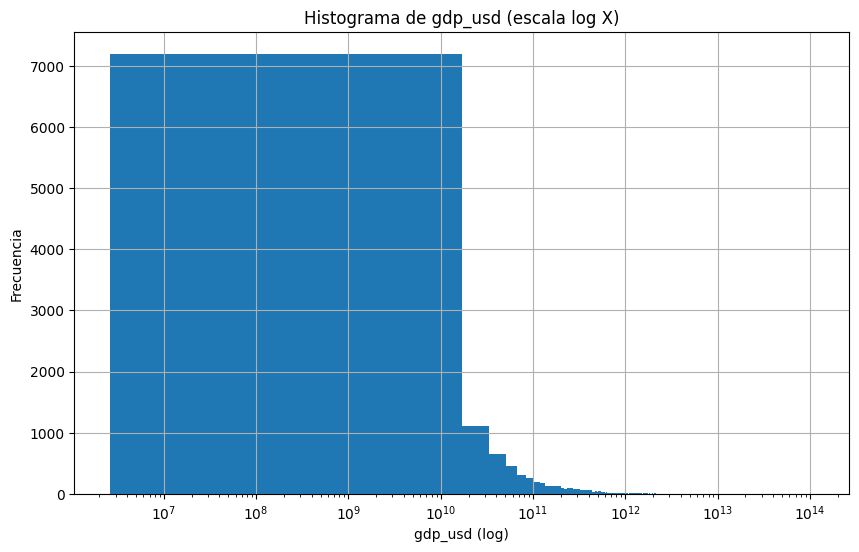

In [ ]:

ax = df['gdp_usd'].dropna().hist(bins='auto')
plt.xscale('log'); plt.title('Histograma de gdp_usd (escala log X)')
plt.xlabel('gdp_usd (log)'); plt.ylabel('Frecuencia')
plt.show()

Haces el histograma sobre los valores originales de gdp_usd y luego cambias la escala del eje X a logarítmica con plt.xscale('log'). El conteo por bin lo calcula matplotlib en la escala lineal original y después lo “proyecta” en un eje log. El resultado comprime la cola derecha (valores gigantes) y expande la zona de valores pequeños, haciéndolos más visibles. Ventajas: no alteras los datos ni sus unidades (siguen siendo USD). Inconvenientes: los bins dejan de ser uniformes en el espacio log, lo que puede dificultar comparaciones visuales entre barras.

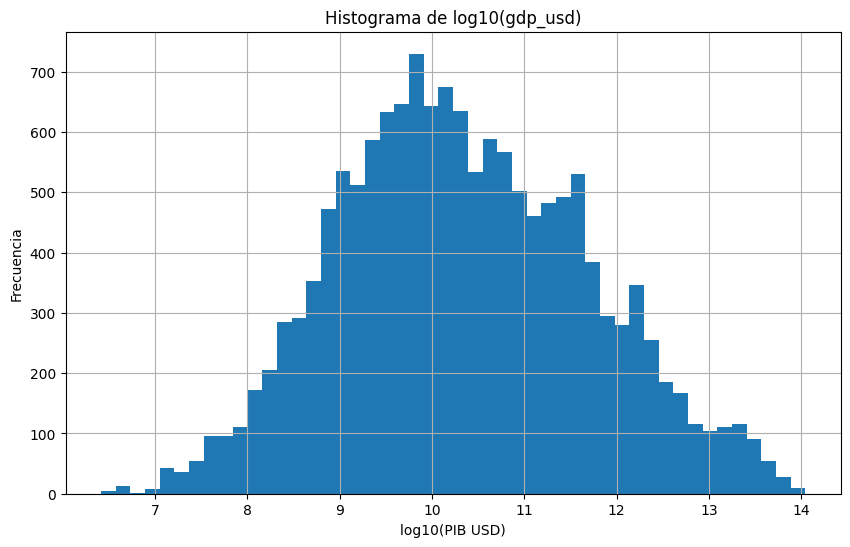

In [ ]:
x = np.log10(df['gdp_usd'].dropna())
x.hist(bins='auto'); plt.title('Histograma de log10(gdp_usd)')
plt.xlabel('log10(PIB USD)'); plt.ylabel('Frecuencia')
plt.show()

Transformación log10 de la variable
Primero transformas la serie: x = np.log10(gdp_usd), y luego haces el histograma sobre x en escala lineal. Así, los bins sí son uniformes en el espacio log (cada barra cubre el mismo rango de órdenes de magnitud). Suele “normalizar” visualmente distribuciones muy sesgadas y facilita ver estructura interna. Ventajas: bins uniformes en log y mejor legibilidad de diferencias por órdenes de magnitud. Inconvenientes: cambias las unidades (ya no son USD sino log10(USD)) y debes filtrar valores no positivos (no se puede aplicar log a 0 o negativos).

#0

PIBS POR REGION


## 6. Univariante
**Qué hacemos**: Visualizamos la distribución del **PIB** (log10) y la dispersión del **PIB per cápita** por región.  
**Cómo leerlo**: Logs ayudan a quitar sesgo de colas. Boxplots comparan mediana y dispersión entre regiones.


TABLA RESUMEN: PIB por país (último año) en log10 y USD

In [ ]:
assert col_year in df.columns and col_gdp in df.columns, "Faltan col_year/col_gdp en df"

latest = int(df[col_year].dropna().max())
dfl = df[df[col_year] == latest].copy()
x = np.log10(dfl.loc[dfl[col_gdp] > 0, col_gdp]).dropna()
usd = dfl.loc[dfl[col_gdp] > 0, col_gdp].dropna()

def q(s, p): 
    return float(np.nanpercentile(s, p))

summary = {
    "Año": latest,
    "n_paises": int(x.shape[0]), #en BASE log10
    "log10_media": float(np.nanmean(x)),
    "log10_mediana": float(np.nanmedian(x)),
    "log10_std": float(np.nanstd(x, ddof=1)) if x.shape[0]>1 else float("nan"),
    "log10_min": float(np.nanmin(x)),
    "log10_p10": q(x,10),
    "log10_p25": q(x,25),
    "log10_p75": q(x,75),
    "log10_p90": q(x,90),
    "log10_max": float(np.nanmax(x)),
    "USD_media_geom": float(10**np.nanmean(x)),  # Equivalentes en USD usando base log
    "USD_mediana": float(10**np.nanmedian(x)),
    "USD_p10": float(10**q(x,10)),
    "USD_p25": float(10**q(x,25)),
    "USD_p75": float(10**q(x,75)),
    "USD_p90": float(10**q(x,90)),
    "USD_min": float(10**np.nanmin(x)),
    "USD_max": float(10**np.nanmax(x)),
    "USD_media_arit": float(np.nanmean(usd)), #Media aritmética en USD para comparar
}

summary_df = pd.DataFrame([summary])

# Tabla de AREA en log10 (cont / %)


In [ ]:
bins = [-np.inf, 9, 10, 10.5, 11, 11.5, 12, np.inf]
labels = ["<9", "9–10", "10–10.5", "10.5–11", "11–11.5", "11.5–12", ">12"]
cats = pd.cut(x, bins=bins, labels=labels, include_lowest=True, right=True)
band_counts = cats.value_counts().reindex(labels, fill_value=0)
band_pct = (band_counts / band_counts.sum() * 100).round(2)
bandas_df = pd.DataFrame({"Conteo": band_counts.astype(int), "Porcentaje(%)": band_pct}, index=labels)

In [ ]:
# Segment 
segmento = pd.cut(x, bins=[-np.inf,10,12,np.inf], labels=["Pequeño (<10)", "Medio (10–12)", "Grande (≥12)"])
seg_counts = segmento.value_counts().reindex(["Pequeño (<10)","Medio (10–12)","Grande (≥12)"], fill_value=0)
seg_pct = (seg_counts/seg_counts.sum()*100).round(2)
segmentos_df = pd.DataFrame({"Conteo": seg_counts.astype(int), "Porcentaje(%)": seg_pct})

In [ ]:
def fmt_money(v):
    try:
        return f"${v:,.0f}"
    except Exception:
        return v

fmt_cols = [c for c in summary_df.columns if c.startswith("USD_")]
summary_fmt = summary_df.copy()
for c in fmt_cols:
    summary_fmt[c] = summary_fmt[c].map(fmt_money)

display(summary_fmt)
display(bandas_df)
display(segmentos_df)

# Formateamos las tables con los dats actual


,Año,n_paises,log10_media,log10_mediana,log10_std,log10_min,log10_p10,log10_p25,log10_p75,log10_p90,log10_max,USD_media_geom,USD_mediana,USD_p10,USD_p25,USD_p75,USD_p90,USD_min,USD_max,USD_media_arit
0,2024,231,11.133019,10.969403,1.25044,8.205071,9.439577,10.289346,12.06765,12.788619,14.046312,"$135,837,225,405","$93,197,329,012","$2,751,544,520","$19,469,086,819","$1,168,558,064,468","$6,146,374,383,733","$160,350,640","$111,252,997,846,886","$3,961,173,935,501"


,Conteo,Porcentaje(%)
<9,6,2.60
9–10,32,13.85
10–10.5,39,16.88
10.5–11,41,17.75
11–11.5,25,10.82
11.5–12,28,12.12
>12,60,25.97


,Conteo,Porcentaje(%)
gdp_usd,,
Pequeño (<10),38,16.45
Medio (10–12),133,57.58
Grande (≥12),60,25.97


DataFrame df con columnas: 'year' y 'gdp_usd' : 

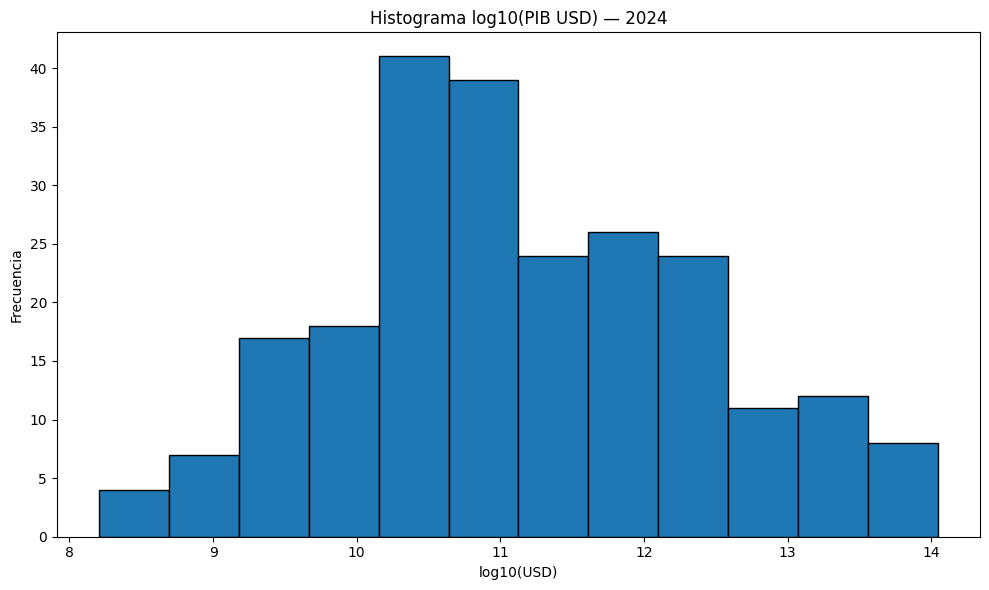

In [ ]:
mask_2024 = df['year'] == 2024 #  en 2024
x = np.log10(df.loc[mask_2024, 'gdp_usd']).replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(10, 6)) 
plt.hist(x, bins=12, edgecolor='black')
plt.title('Histograma log10(PIB USD) — 2024')
plt.xlabel('log10(USD)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


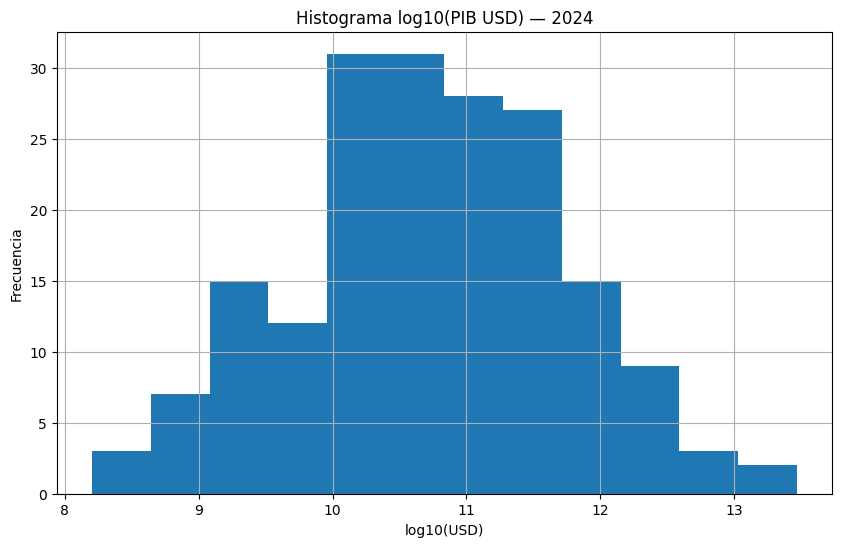

C:\Users\Asus Vivobook\AppData\Local\Temp\ipykernel_34604\4030624623.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=labels, showfliers=False)


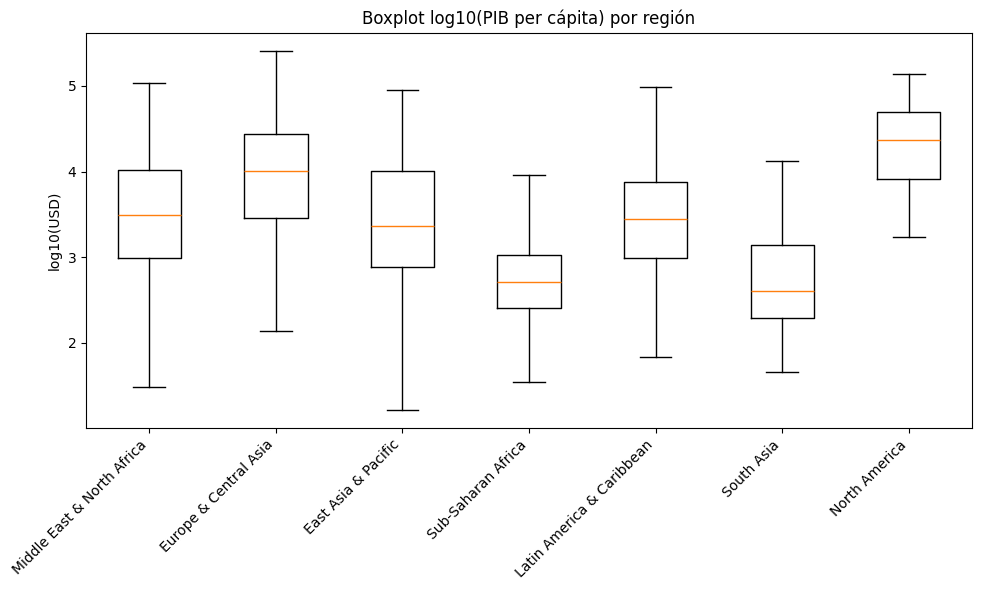

In [ ]:
orden_regiones = [
    'Middle East & North Africa',
    'Europe & Central Asia',
    'East Asia & Pacific',
    'Sub-Saharan Africa',
    'Latin America & Caribbean',
    'South Asia',
    'North America'
]

data_box = [
    np.log10(
        df.loc[df['region'] == r, 'gdppc_usd']
          .replace([np.inf, -np.inf], np.nan)
          .dropna()
    )
    for r in orden_regiones
]

plt.figure(figsize=(14, 8))
plt.boxplot(data_box, labels=orden_regiones, showfliers=True)
plt.title('Boxplot log10(PIB per cápita) por región')
plt.ylabel('log10(USD)')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()




PARA ITERAR CON LOS LOG BASE 10 USAMOS:

In [ ]:
####################################################################################################################O.o
df_plot = df_plot[[COL_REGION, COL_GDPPC]].copy()
df_plot[COL_GDPPC] = pd.to_numeric(df_plot[COL_GDPPC], errors="coerce")
df_plot = df_plot.dropna(subset=[COL_REGION, COL_GDPPC])
df_plot = df_plot[df_plot[COL_GDPPC] > 0]  # evita log de valores no positivos
df_plot["log10_gdppc"] = np.log10(df_plot[COL_GDPPC])
####################################################################################################################O.o

Ordenamos regiones por mediana

In [ ]:
orden_regiones = (
    df_plot.groupby(COL_REGION)["log10_gdppc"]
    .median()
    .sort_values()
    .index
)

#1

Análisis univariante de PIB por países 

In [ ]:
# ======= Bandas y segmentos =======
bins   = [-np.inf, 9, 10, 10.5, 11, 11.5, 12, np.inf]
labels = ["<9", "9–10", "10–10.5", "10.5–11", "11–11.5", "11.5–12", ">12"]
cats = pd.cut(x_log, bins=bins, labels=labels, include_lowest=True, right=True)
band_counts = pd.Series(cats).value_counts().reindex(labels, fill_value=0)
band_pct = (band_counts / band_counts.sum() * 100).round(2)
bandas_df = pd.DataFrame({
    "Banda log10": labels,
    "Conteo": band_counts.values.astype(int),
    "Porcentaje(%)": band_pct.values
})

segmento = pd.cut(x_log, bins=[-np.inf, 10, 12, np.inf],
                  labels=["Pequeño (<10)", "Medio (10–12)", "Grande (≥12)"])
seg_counts = pd.Series(segmento).value_counts().reindex(["Pequeño (<10)", "Medio (10–12)", "Grande (≥12)"], fill_value=0)
seg_pct = (seg_counts / seg_counts.sum() * 100).round(2)
segmentos_df = pd.DataFrame({
    "Segmento": seg_counts.index,
    "Conteo": seg_counts.values.astype(int),
    "Porcentaje(%)": seg_pct.values})

Top/Bottom 10

In [ ]:

top10 = dfl[[COL_COUNTRY, COL_GDP]].sort_values(COL_GDP, ascending=False).head(10).reset_index(drop=True)
bot10 = dfl[[COL_COUNTRY, COL_GDP]].sort_values(COL_GDP, ascending=True ).head(10).reset_index(drop=True)
top10 = top10.rename(columns={COL_COUNTRY: "País", COL_GDP: "PIB_USD"})
bot10 = bot10.rename(columns={COL_COUNTRY: "País", COL_GDP: "PIB_USD"})
top10["PIB_USD"] = top10["PIB_USD"].map(fmt_money)
bot10["PIB_USD"] = bot10["PIB_USD"].map(fmt_money)

Encabezados de tit

In [ ]:
summary_print = summary_df.copy()
for c in [c for c in summary_print.columns if c.startswith("USD_")]:
    summary_print[c] = summary_print[c].map(fmt_money)

print("\n=== RESUMEN UNIVARIANTE (último año) ===")
print(summary_print.to_string(index=False))

print("\n=== BANDAS log10(PIB) ===")
print(bandas_df.to_string(index=False))

print("\n=== SEGMENTOS (Pequeño/Medio/Grande) ===")
print(segmentos_df.to_string(index=False))

print("\n=== TOP 10 PIB (USD) ===")
print(top10.to_string(index=False))

print("\n=== BOTTOM 10 PIB (USD) ===")
print(bot10.to_string(index=False))

In [ ]:
#plotsbgggg
plt.figure(figsize=(10,6))
plt.hist(dfl[COL_GDP].values, bins="auto")
plt.title(f"Histograma PIB (USD) — {latest}")
plt.xlabel("USD"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

In [ ]:
# Histograma de PIB (log10) en el último año

In [ ]:

if col_year and col_gdp:
    latest = int(df[col_year].dropna().max())
    dfl = df[df[col_year] == latest]
    x = np.log10(dfl.loc[dfl[col_gdp] > 0, col_gdp])
    ax = x.hist(bins="auto")
    plt.title(f"Histograma log10(PIB USD) — {latest}")
    plt.xlabel("log10(USD)"); plt.ylabel("Frecuencia"); plt.show()

✅ Usando df ya cargado en memoria con forma: (17195, 9)
Columnas detectadas/fijadas:
 - País   : country
 - Año    : year
 - PIB    : gdp_usd

=== RESUMEN UNIVARIANTE (último año) ===
 Año  n_paises  log10_media  log10_mediana  log10_std  log10_min  log10_p10  log10_p25  log10_p75  log10_p90  log10_max   USD_media_geom     USD_mediana        USD_p10         USD_p25            USD_p75            USD_p90      USD_min              USD_max     USD_media_arit
2024       231    11.133019      10.969403    1.25044   8.205071   9.439577  10.289346   12.06765  12.788619  14.046312 $135,837,225,405 $93,197,329,012 $2,751,544,520 $19,469,086,819 $1,168,558,064,468 $6,146,374,383,733 $160,350,640 $111,252,997,846,886 $3,961,173,935,501

=== BANDAS log10(PIB) ===
Banda log10  Conteo  Porcentaje(%)
         <9       6           2.60
       9–10      32          13.85
    10–10.5      39          16.88
    10.5–11      41          17.75
    11–11.5      25          10.82
    11.5–12      28          

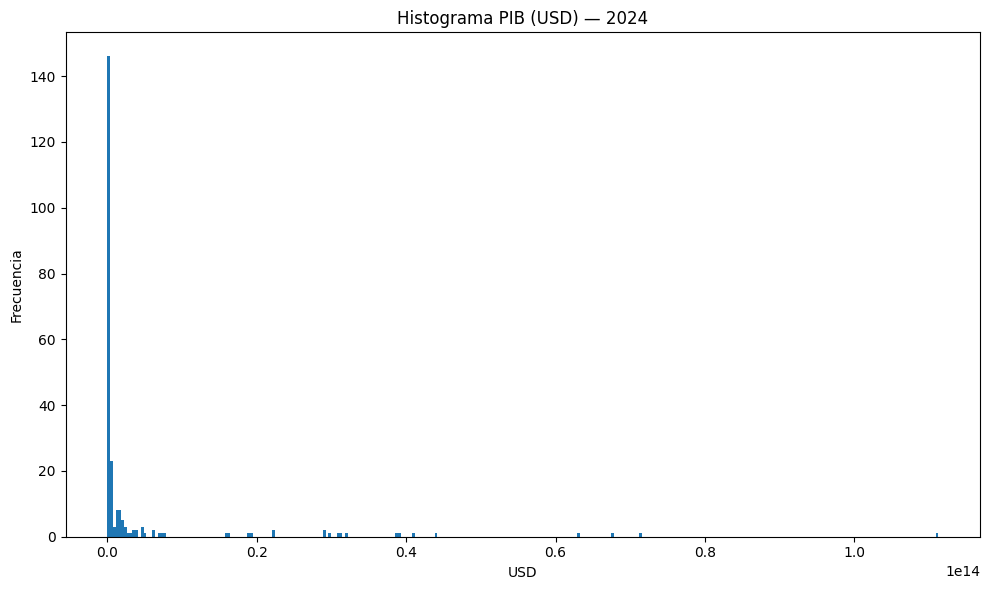

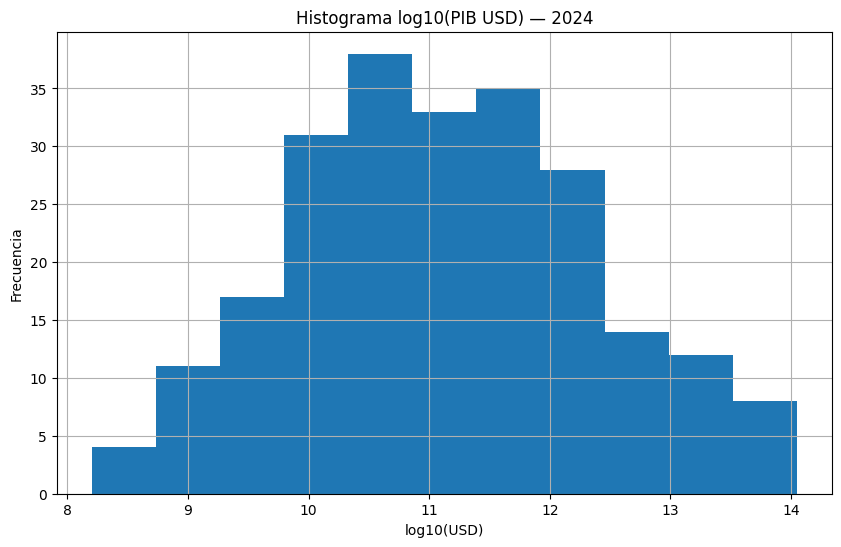

In [ ]:
# Boxplot de PIB per cápita por región
if col_region and "gdp_pc" in df.columns:
    vals, labels = [], []
    for r in df[col_region].dropna().unique():
        series = df.loc[df[col_region]==r, "gdp_pc"].dropna()
        if len(series)>0:
            vals.append(np.log10(series[series>0]))
            labels.append(str(r))
    if vals:
        plt.boxplot(vals, labels=labels, showfliers=False)
        plt.title("Boxplot log10(PIB per cápita) por región")
        plt.ylabel("log10(USD)"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


Mini-glosario (rápido)

log10(x): diferencia de +1 implica ×10 en USD; +0,3 ≈ ×2.

Media geométrica: la “media natural” cuando se trabaja en log; menos sesgada por outliers.

IQR (p75–p25): dispersión robusta del 50% central.


## 8. Composición regional (H4)
**Qué hacemos**: Comparamos el **% del PIB mundial** por región en el último año y contra un año anterior (si existe).  
**Resultado**: Tabla y barras comparativas.


VISION TEMPORAL PIB

In [ ]:
#2

TOTAL / REG

In [ ]:
totals = dfl.groupby(region_col, dropna=False)[gdp_col].sum(min_count=1).rename("PIB_total_USD")


países por reg

In [ ]:
n_countries = dfl.dropna(subset=[gdp_col]).groupby(region_col)[gdp_col].size().rename("n_paises")


Media y mediana de PIB por país 

In [ ]:

mean_gdp = dfl.groupby(region_col)[gdp_col].mean().rename("PIB_medio_USD")
median_gdp = dfl.groupby(region_col)[gdp_col].median().rename("PIB_mediana_USD")

PIB total, % mundial, nº países, media, mediana

In [ ]:
tabla = (
    pd.concat([totals, n_countries, mean_gdp, median_gdp], axis=1)
      .sort_values("PIB_total_USD", ascending=False)
      .reset_index()
)


world_total = tabla["PIB_total_USD"].sum(skipna=True)
tabla["%_del_mundial"] = 100 * tabla["PIB_total_USD"] / world_total


tabla.insert(0, "rank", np.arange(1, len(tabla) + 1))

In [ ]:
def human_money(x):
    if pd.isna(x): return ""
    for unit in ["", "K", "M", "B", "T"]:
        if abs(x) < 1000.0:
            return f"{x:,.0f}{unit}"
        x /= 1000.0
    return f"{x:,.0f}P"

tabla_fmt = tabla.copy()
for c in ["PIB_total_USD","PIB_medio_USD","PIB_mediana_USD"]:
    tabla_fmt[c] = tabla_fmt[c].apply(human_money)
tabla_fmt["%_del_mundial"] = tabla["%_del_mundial"].map(lambda v: f"{v:.2f}%")

print("\nTabla PIB por región" + (f" — {latest_year}" if latest_year else "") + ":")
print(tabla_fmt.to_string(index=False))

Gráfico de barras con etiquetas valores en trillones LOG(10)

In [ ]:

plt.figure(figsize=(11,6))
order = tabla.sort_values("PIB_total_USD", ascending=True)
bars = plt.barh(order[region_col].astype(str), order["PIB_total_USD"])
plt.title(f"PIB total por región" + (f" — {latest_year}" if latest_year else ""))
plt.xlabel("PIB (USD)")


for b, val in zip(bars, order["PIB_total_USD"]):
    plt.text(b.get_width()*1.01, b.get_y()+b.get_height()/2,
             human_money(val), va="center")

plt.tight_layout()
plt.show()

Top países por región 


Tabla PIB por región — 2024:
 rank                     Region PIB_total_USD  n_paises PIB_medio_USD PIB_mediana_USD %_del_mundial
    1              North America           31T         3           10T              2T        29.16%
    2        East Asia & Pacific           29T        27            1T             46B        27.17%
    3      Europe & Central Asia           29T        50          582B            128B        26.99%
    4  Latin America & Caribbean            7T        34          199B             31B         6.29%
    5 Middle East & North Africa            5T        19          260B            160B         4.58%
    6                 South Asia            5T         5          902B             99B         4.19%
    7         Sub-Saharan Africa            2T        45           39B             19B         1.61%

Guardado CSV: C:\Users\Asus Vivobook\Downloads\gdp_by_region_enriched.csv
Guardado XLSX: C:\Users\Asus Vivobook\Downloads\gdp_by_region_enriched.xlsx


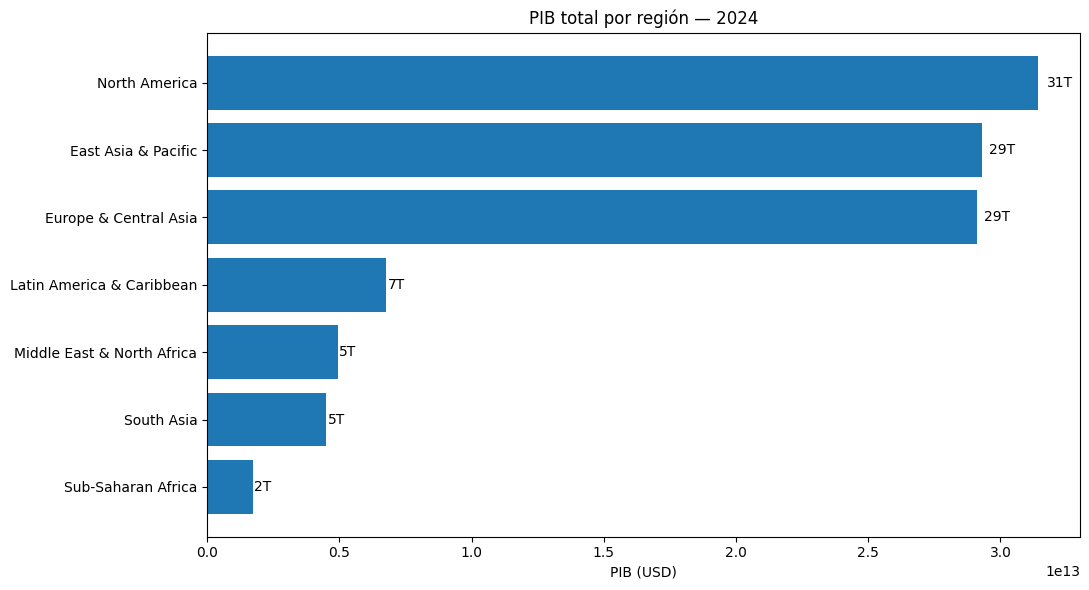


Top 3 países por PIB en cada región — 2024:

East Asia & Pacific:
 - China: 19T
 - Japan: 4T
 - Australia: 2T

Europe & Central Asia:
 - Germany: 5T
 - United Kingdom: 4T
 - France: 3T

Latin America & Caribbean:
 - Brazil: 2T
 - Mexico: 2T
 - Argentina: 633B

Middle East & North Africa:
 - Saudi Arabia: 1T
 - Israel: 540B
 - United Arab Emirates: 537B

North America:
 - United States: 29T
 - Canada: 2T
 - Bermuda: 9B

South Asia:
 - India: 4T
 - Bangladesh: 450B
 - Sri Lanka: 99B

Sub-Saharan Africa:
 - South Africa: 400B
 - Nigeria: 188B
 - Kenya: 124B


In [ ]:

try:
    if country_col:
        dftop = (
            dfl[[region_col, country_col, gdp_col]]
            .sort_values([region_col, gdp_col], ascending=[True, False])
            .groupby(region_col)
            .head(3)
        )
        print("\nTop 3 países por PIB en cada región" + (f" — {latest_year}" if latest_year else "") + ":")
        for reg, chunk in dftop.groupby(region_col):
            print(f"\n{reg}:")
            for _, r in chunk.iterrows():
                print(f" - {r[country_col]}: {human_money(r[gdp_col])}")
except Exception as e:
    print(f"(Aviso) No se pudo generar el top por región: {e}")


## Series temporales y contribución al crecimiento
 Mostramos PIB mundial en el tiempo y **top contribuyentes** al último aumento anual del PIB.  
Line chart y barras Top-N.


Participación regional en PIB mundial — 2024:


,%_mundial
Region,
North America,29.162630
East Asia & Pacific,27.173753
Europe & Central Asia,26.992884
Latin America & Caribbean,6.290317
Middle East & North Africa,4.582997
South Asia,4.185503
Sub-Saharan Africa,1.611914


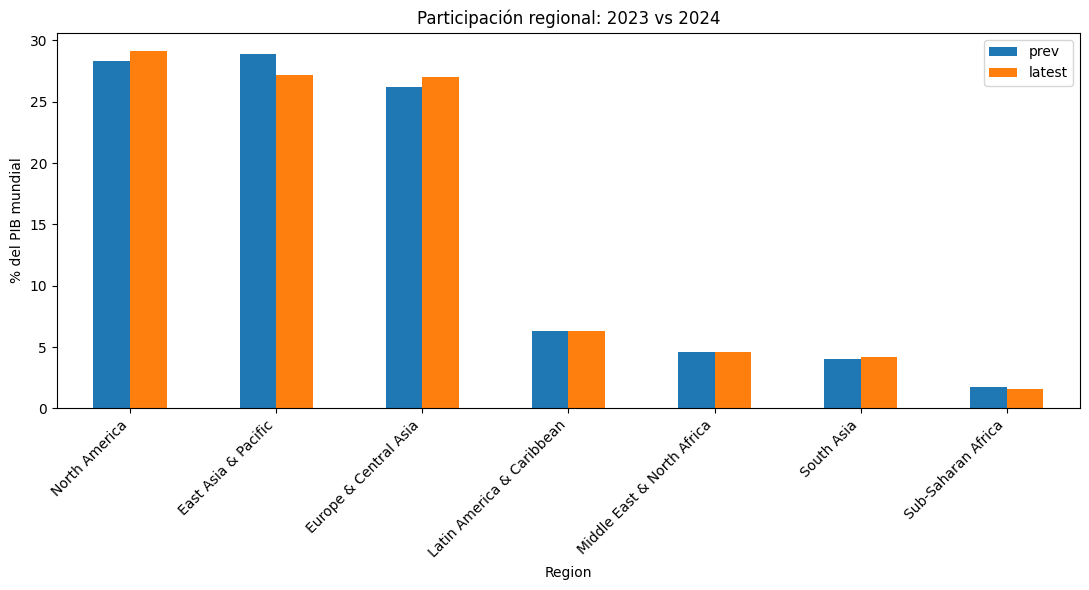

In [ ]:
if col_region and col_year and col_gdp:
    latest = int(df[col_year].dropna().max())
    prevs = sorted(df[col_year].dropna().unique())
    prev = prevs[-2] if len(prevs)>=2 else None

    def shares_for(year):
        d = df[df[col_year]==year]
        g = d.groupby(col_region)[col_gdp].sum(min_count=1)
        return (100*g/g.sum()).sort_values(ascending=False)

    s_latest = shares_for(latest)
    print(f"Participación regional en PIB mundial — {latest}:")
    display(s_latest.to_frame(name="%_mundial"))

    if prev:
        s_prev = shares_for(prev).reindex(s_latest.index).fillna(0)
        comp = pd.DataFrame({"prev": s_prev, "latest": s_latest})
        comp.plot(kind="bar", figsize=(11,6))
        plt.title(f"Participación regional: {prev} vs {latest}")
        plt.ylabel("% del PIB mundial"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

PIB POR REGIÓN

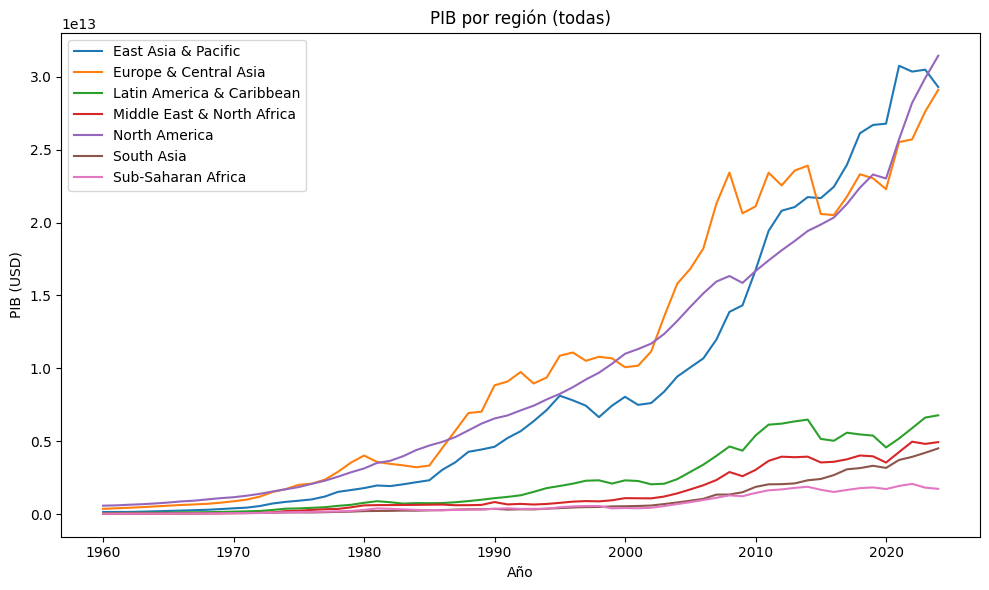

In [ ]:
if col_region and col_year and col_gdp and col_region in df.columns:
    regiones = sorted(df[col_region].dropna().unique())
    if len(regiones) > 0:
        plt.figure(figsize=(10,6))
        for r in regiones:
            ts = (df[df[col_region]==r]
                  .groupby(col_year)[col_gdp].sum(min_count=1)
                  .sort_index())
            plt.plot(ts.index, ts.values, label=r)
        plt.title("PIB por región (todas)"); plt.xlabel("Año"); plt.ylabel("PIB (USD)")
        plt.legend(); plt.tight_layout(); plt.show()

HISTOGRAMA PIB MUNDIAL

In [ ]:
if col_year and col_gdp:
    world_ts = df.groupby(col_year)[col_gdp].sum(min_count=1).sort_index()
    plt.plot(world_ts.index, world_ts.values)
    plt.title("PIB mundial en el tiempo"); plt.xlabel("Año"); plt.ylabel("PIB (USD)"); plt.show()

crecimiento: Δ país / ΣΔ mundial

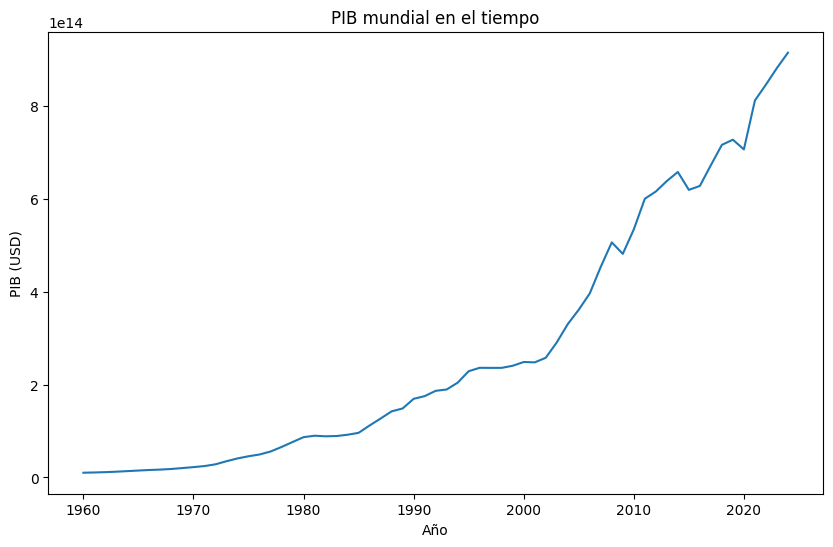

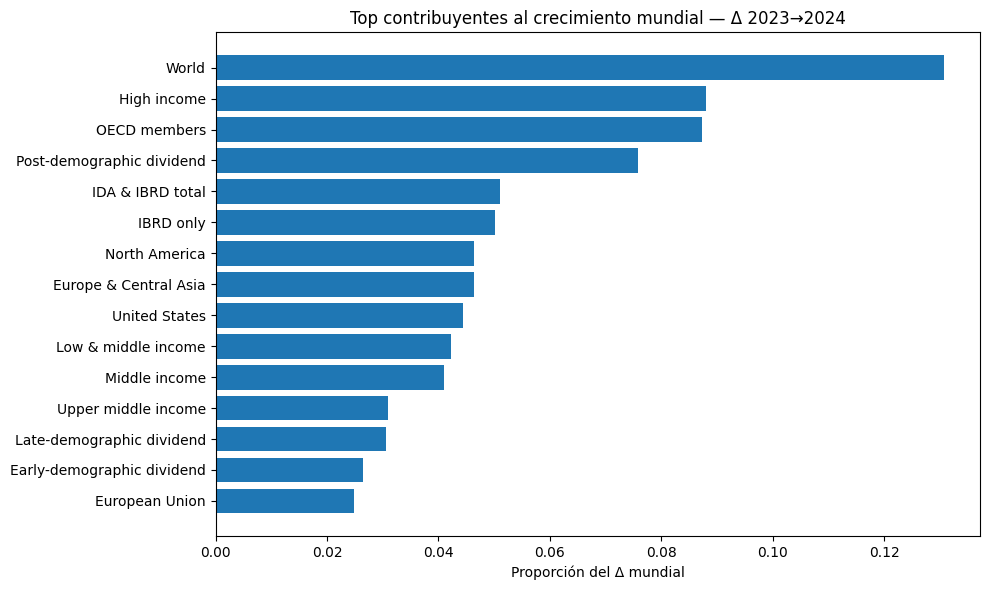

In [ ]:
if col_year and col_gdp and col_country:
    world = df.groupby(col_year)[col_gdp].sum(min_count=1).sort_index()
    world_delta = world.diff()
    df["gdp_delta"] = df.groupby(col_country)[col_gdp].diff()
    df = df.merge(world_delta.rename("world_delta"), left_on=col_year, right_index=True, how="left")
    df["contrib_world_growth"] = np.where(df["world_delta"].abs()>0, df["gdp_delta"]/df["world_delta"], np.nan)

    last = int(df[col_year].dropna().max())
    top = (df[df[col_year]==last].set_index(col_country)["contrib_world_growth"]
            .dropna().sort_values(ascending=False).head(15))
    if not top.empty:
        plt.barh(top.index[::-1], top.values[::-1])
        plt.title(f"Top contribuyentes al crecimiento mundial — Δ {last-1}→{last}")
        plt.xlabel("Proporción del Δ mundial"); plt.tight_layout(); plt.show()


Perspectiva regional: tabla y barra


Tabla regional (último año):
                            PIB_total_USD  %_mundial
Region                                              
North America                3.143512e+13  29.162630
East Asia & Pacific          2.929126e+13  27.173753
Europe & Central Asia        2.909630e+13  26.992884
Latin America & Caribbean    6.780489e+12   6.290317
Middle East & North Africa   4.940127e+12   4.582997
South Asia                   4.511658e+12   4.185503
Sub-Saharan Africa           1.737522e+12   1.611914


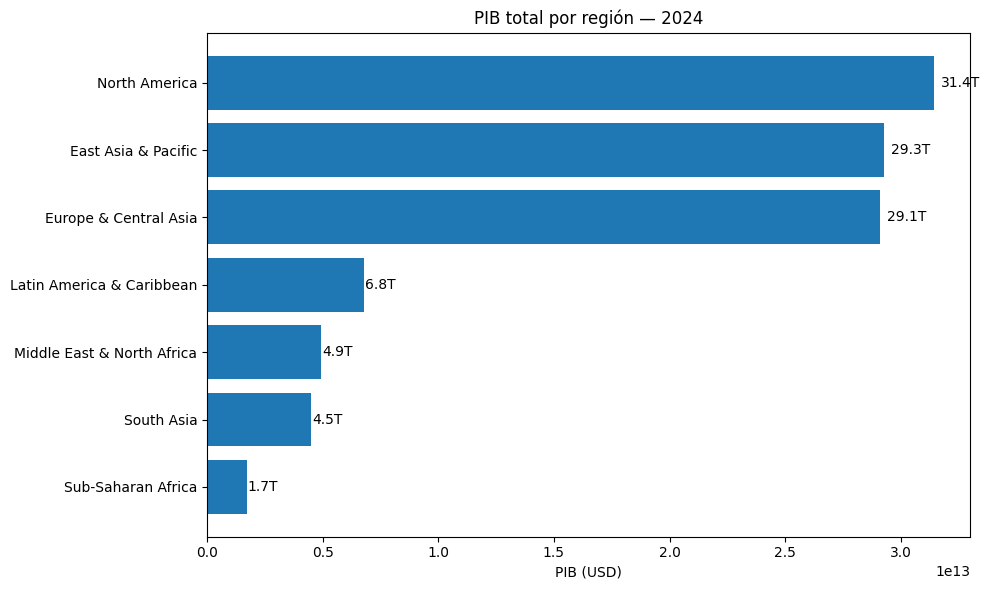

In [ ]:
if col_region and col_year and col_gdp and col_region in df.columns:
    latest = int(df[col_year].dropna().max())
    dfl = df[df[col_year]==latest]
    gdp_region = dfl.groupby(col_region, dropna=True)[col_gdp].sum(min_count=1).sort_values(ascending=False)
    if gdp_region.notna().any():
        share = 100 * gdp_region / gdp_region.sum()
        tabla_region = pd.DataFrame({"PIB_total_USD": gdp_region, "%_mundial": share})
        print("\nTabla regional (último año):")
        print(tabla_region)

        order = tabla_region.sort_values("PIB_total_USD", ascending=True)
        plt.figure(figsize=(10,6))
        plt.barh(order.index.astype(str), order["PIB_total_USD"])
        for y, v in enumerate(order["PIB_total_USD"].values):
            try:
                plt.text(v*1.01, y, f"{v/1e12:.1f}T", va="center")
            except Exception:
                pass
        plt.title(f"PIB total por región — {latest}")
        plt.xlabel("PIB (USD)"); plt.tight_layout(); plt.show()
    else:
        print("No")

#2 OR #3

In [ ]:
Mini-glosario (rápido)

log10(x): diferencia de +1 implica ×10 en USD; +0,3 ≈ ×2.

Media geométrica: la “media natural” cuando se trabaja en log; menos sesgada por outliers.

IQR (p75–p25): dispersión robusta del 50% central.

Análisis univariante de PIB per cápita 

# Top/Bottom por PIB pc (    # Boxplot regional en log10(PIB pc))

Columnas para PIB pc:
 - País   : country
 - Año    : year
 - PIB    : gdp_usd
 - Población: population
 - Región : Region

=== RESUMEN UNIVARIANTE PIB per cápita (USD) ===
 Año  n_paises  log10_media  log10_mediana  log10_std  log10_min  log10_p10  log10_p25  log10_p75  log10_p90  log10_max USD_media_geom USD_mediana USD_p10 USD_p25 USD_p75 USD_p90 USD_min  USD_max USD_media_arit
2024       231     3.886661       3.886222   0.609401   2.187324   3.080183   3.413779   4.378743   4.721289   5.142812         $7,703      $7,695  $1,203  $2,593 $23,919 $52,637    $154 $138,935        $18,101

=== BANDAS log10(PIB pc) ===
Banda log10  Conteo  Porcentaje(%)
       <2.5       1           0.43
      2.5–3      17           7.36
      3–3.5      52          22.51
      3.5–4      58          25.11
      4–4.5      58          25.11
      4.5–5      41          17.75
         >5       4           1.73

=== SEGMENTOS PIB pc ===
                Segmento  Conteo  Porcentaje(%)
         Muy bajo (<$

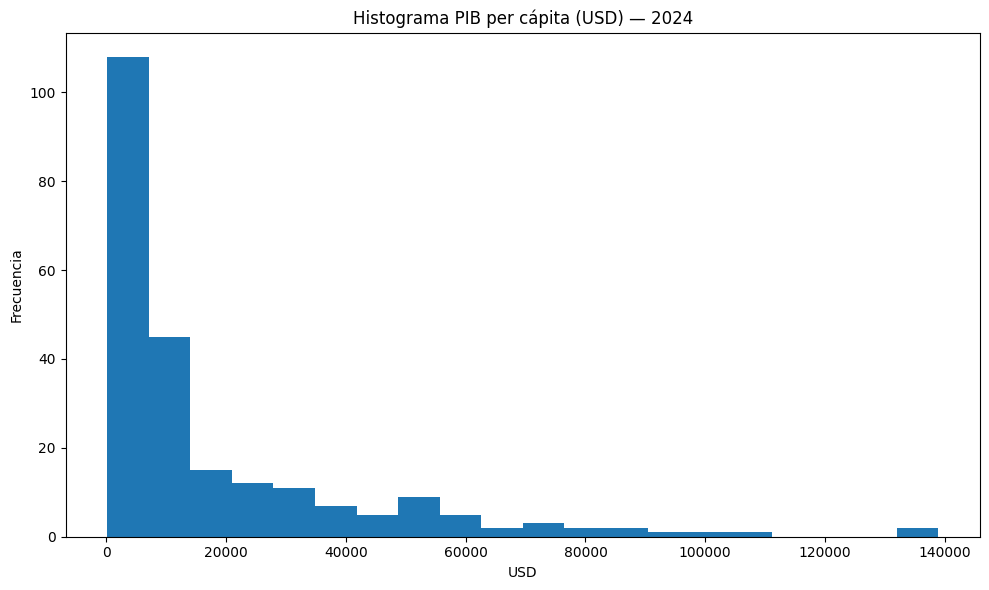

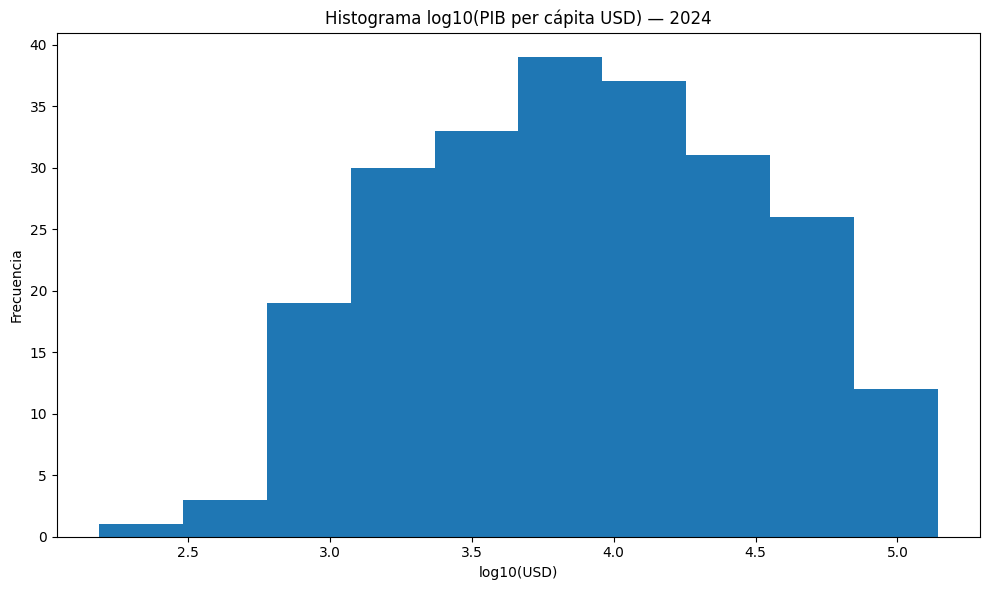

C:\Users\Asus Vivobook\AppData\Local\Temp\ipykernel_30228\181051839.py:169: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=labels, showfliers=False)


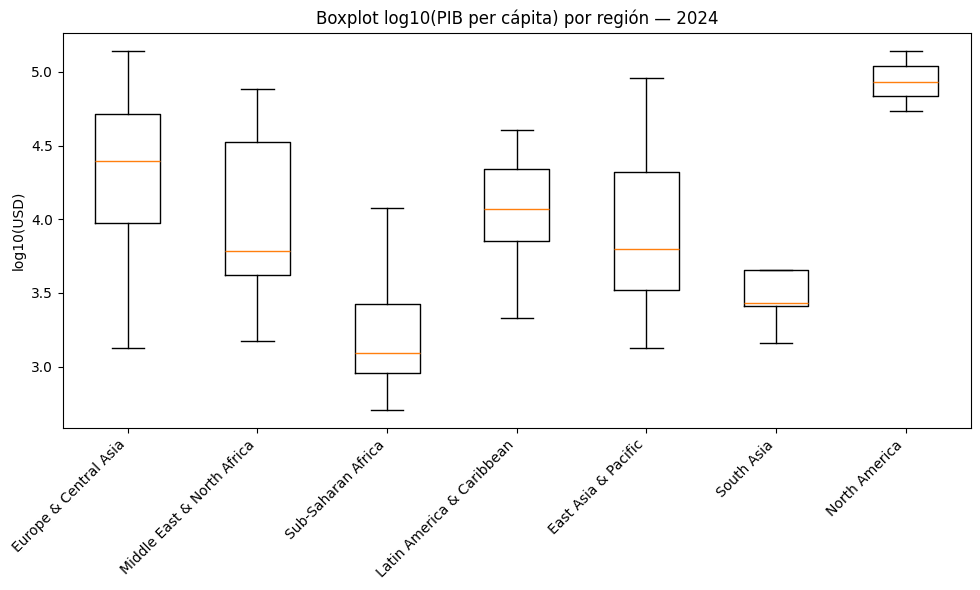

In [ ]:

top10_pc = dfl[[COL_COUNTRY, 'gdp_pc']].sort_values('gdp_pc', ascending=False).head(10).reset_index(drop=True)
bot10_pc = dfl[[COL_COUNTRY, 'gdp_pc']].sort_values('gdp_pc', ascending=True ).head(10).reset_index(drop=True)
fmt = lambda v: f"${v:,.0f}"
top10_pc['PIB_pc_USD'] = top10_pc['gdp_pc'].map(fmt); top10_pc = top10_pc.drop(columns=['gdp_pc'])
bot10_pc['PIB_pc_USD'] = bot10_pc['gdp_pc'].map(fmt); bot10_pc = bot10_pc.drop(columns=['gdp_pc'])


plt.figure(figsize=(10,6))
plt.hist(dfl['gdp_pc'].values, bins="auto")
plt.title(f"Histograma PIB per cápita (USD) — {latest}")
plt.xlabel("USD"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,6))
plt.hist(x_log, bins="auto")
plt.title(f"Histograma log10(PIB per cápita USD) — {latest}")
plt.xlabel("log10(USD)"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

if COL_REGION:
    vals, labels = [], []
    for r in dfl[COL_REGION].dropna().unique():
        s = dfl.loc[dfl[COL_REGION]==r, 'gdp_pc'].dropna()
        s = s[s>0]
        if s.size>0:
            vals.append(np.log10(s.values))
            labels.append(str(r))
    if vals:
        plt.figure(figsize=(10,6))
        plt.boxplot(vals, labels=labels, showfliers=False)
        plt.title(f"Boxplot log10(PIB per cápita) por región — {latest}")
        plt.ylabel("log10(USD)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout(); plt.show()


#texts  (iht plot)
summary_pc_print = summary_pc_df.copy()
for c in [c for c in summary_pc_print.columns if c.startswith("USD_")]:
    summary_pc_print[c] = summary_pc_print[c].map(fmt)
print("\n=== RESUMEN UNIVARIANTE PIB per cápita (USD) ===")
print(summary_pc_print.to_string(index=False))

print("\n=== BANDAS log10(PIB pc) ===")
print(bandas_pc_df.to_string(index=False))

print("\n=== SEGMENTOS PIB pc ===")
print(segmentos_pc_df.to_string(index=False))

print("\n=== TOP 10 PIB per cápita ===")
print(top10_pc.to_string(index=False))

print("\n=== BOTTOM 10 PIB per cápita ===")
print(bot10_pc.to_string(index=False))

## Bivariante (contraste de hipótesis H1–H3)
Calculamos **correlaciones** y ajustamos una **recta de tendencia** simple donde aplica.
Se imprime la magnitud y signo, y una lectura rápida.

Multivariante: PIB vs PIB per cápita (df con columnas 'country','year','gdp_usd' y 'gdp_pc'+ "country_pop"): CORRELACIONES

In [ ]:
#4

Logaritmos

In [ ]:
dfl['log_gdp']   = np.log10(dfl[COL_GDP])
dfl['log_gdppc'] = np.log10(dfl['gdp_pc'])
if COL_POP and COL_POP in dfl.columns:
    dfl['log_pop'] = np.log10(dfl[COL_POP])

Pearson y Spearman

In [ ]:
def corr_pair(a, b):
    a = pd.Series(a).astype(float)
    b = pd.Series(b).astype(float)
    pear = a.corr(b, method='pearson')
    spear = a.corr(b, method='spearman')
    return pear, spear

pear_gdp_pc, spear_gdp_pc = corr_pair(dfl['log_gdp'], dfl['log_gdppc'])

print(f"Último año: {latest}")
print("\nCorrelación log(PIB) vs log(PIB pc):")
print(f"  Pearson : r = {pear_gdp_pc:.3f}")
print(f"  Spearman: ρ = {spear_gdp_pc:.3f}")

if COL_POP and 'log_pop' in dfl.columns:
    pear_gdp_pop, spear_gdp_pop = corr_pair(dfl['log_gdp'], dfl['log_pop'])
    pear_pc_pop,  spear_pc_pop  = corr_pair(dfl['log_gdppc'], dfl['log_pop'])
    print("\nCorrelación con población (log):")
    print(f"  log(PIB) vs log(Pop)    : Pearson={pear_gdp_pop:.3f}, Spearman={spear_gdp_pop:.3f}")
    print(f"  log(PIB pc) vs log(Pop) : Pearson={pear_pc_pop:.3f}, Spearman={spear_pc_pop:.3f}")


# log(PIB) ~ log(PIB pc)  log(Pop),  residuales de x~z y y~z

In [ ]:
def partial_corr(x, y, z): 
   
    X = pd.DataFrame({'x':x, 'z':z}).dropna()
    Y = pd.DataFrame({'y':y, 'z':z}).dropna()
    J = pd.merge(X, Y, on='z', how='inner')
    if J.shape[0] < 3: 
        return np.nan
    from sklearn.linear_model import LinearRegression
    lr1 = LinearRegression().fit(J[['z']], J['x'])
    lr2 = LinearRegression().fit(J[['z']], J['y'])
    rx = J['x'] - lr1.predict(J[['z']])
    ry = J['y'] - lr2.predict(J[['z']])
    return rx.corr(ry)

pcorr = np.nan
if COL_POP and 'log_pop' in dfl.columns:
    try:
        from sklearn.linear_model import LinearRegression
        pcorr = partial_corr(dfl['log_gdp'], dfl['log_gdppc'], dfl['log_pop'])
        print(f"\nCorrelación PARCIAL: corr(log(PIB), log(PIB pc) | log(Pop)) = {pcorr:.3f}")
    except Exception as e:
        print("\nno.", e)

OLS: log(PIB) ~ log(PIB pc) + log(Pop)

In [ ]:
try:
    import statsmodels.api as sm
    Xvars = ['log_gdppc'] + (['log_pop'] if 'log_pop' in dfl.columns else [])
    X = dfl[Xvars].copy()
    X = sm.add_constant(X)
    y = dfl['log_gdp']
    model = sm.OLS(y, X, missing='drop').fit()
    print("\nOLS: log(PIB) ~ log(PIB pc) + log(Pop)")
    print(model.summary())
except Exception as e:
    print("\nOLS no calculada (instala statsmodels).", e)

Matriz de correlación

Último año: 2024

Correlación log(PIB) vs log(PIB pc):
  Pearson : r = 0.276
  Spearman: ρ = 0.287

Correlación con población (log):
  log(PIB) vs log(Pop)    : Pearson=0.879, Spearman=0.846
  log(PIB pc) vs log(Pop) : Pearson=-0.215, Spearman=-0.225

Correlación PARCIAL: corr(log(PIB), log(PIB pc) | log(Pop)) = 1.000

OLS no calculada (instala statsmodels). No module named 'statsmodels'

Matriz de correlación (logs):
            log_gdp  log_gdppc   log_pop
log_gdp    1.000000   0.276207  0.879446
log_gdppc  0.276207   1.000000 -0.214571
log_pop    0.879446  -0.214571  1.000000


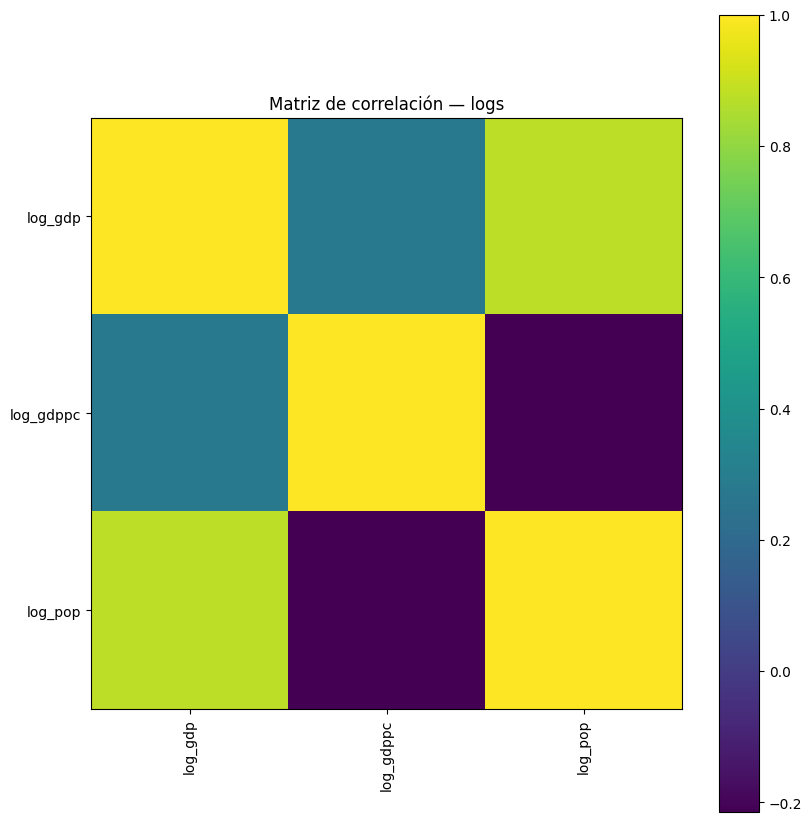

In [ ]:
cols = ['log_gdp','log_gdppc'] + (['log_pop'] if 'log_pop' in dfl.columns else [])
corrM = dfl[cols].corr()
print("\nMatriz de correlación (logs):")
print(corrM)

plt.figure(figsize=(4+1.5*len(cols), 4+1.5*len(cols)))
plt.imshow(corrM, interpolation="nearest")
plt.colorbar(); plt.xticks(range(len(cols)), cols, rotation=90); plt.yticks(range(len(cols)), cols)
plt.title("Matriz de correlación — logs")
plt.tight_layout(); plt.show()



##  Bivariante (contraste de hipótesis H1–H3)
Calculamos **correlaciones** y ajustamos una **recta de tendencia** simple donde aplica.  
Se imprime la magnitud y signo, y una lectura rapida.


In [ ]:

def interpret_corr(r):
    if pd.isna(r): return "sin datos suficientes."
    s = "positiva" if r>0 else "negativa"
    mag = abs(r)
    if mag < 0.2: lvl = "muy débil"
    elif mag < 0.4: lvl = "débil"
    elif mag < 0.6: lvl = "moderada"
    elif mag < 0.8: lvl = "fuerte"
    else: lvl = "muy fuerte"
    return f"{s} ({lvl}, r={r:.3f})"

latest = int(df[col_year].dropna().max()) if col_year else None
dfl = df[df[col_year]==latest].copy() if latest is not None else df.copy()


gdp_pc vs life expectancy

In [ ]:
# H1: 
if "gdp_pc" in dfl.columns and col_life in dfl.columns:
    subset = dfl[(dfl["gdp_pc"]>0) & dfl[col_life].notna()][["gdp_pc", col_life]].dropna()
    if len(subset) >= 3:
        r = np.corrcoef(np.log10(subset["gdp_pc"]), subset[col_life])[0,1]
        print("H1 (Ingresos y salud):", interpret_corr(r))
        plt.scatter(np.log10(subset["gdp_pc"]), subset[col_life], alpha=0.6)
        m,b = np.polyfit(np.log10(subset["gdp_pc"]), subset[col_life], 1)
        xs = np.linspace(np.log10(subset["gdp_pc"]).min(), np.log10(subset["gdp_pc"]).max(), 100)
        plt.plot(xs, m*xs+b, linewidth=2)
        plt.xlabel("log10(PIB per cápita)"); plt.ylabel("Esperanza de vida")
        plt.title(f"H1: Ingresos vs Salud — {latest}"); plt.show()


gdp_pc vs electricity access

In [ ]:
# H2: 
if "gdp_pc" in dfl.columns and col_elec in dfl.columns:
    subset = dfl[(dfl["gdp_pc"]>0) & dfl[col_elec].notna()][["gdp_pc", col_elec]].dropna()
    if len(subset) >= 3:
        r = np.corrcoef(np.log10(subset["gdp_pc"]), subset[col_elec])[0,1]
        print("H2 (Infraestructura y desarrollo):", interpret_corr(r))
        plt.scatter(np.log10(subset["gdp_pc"]), subset[col_elec], alpha=0.6)
        m,b = np.polyfit(np.log10(subset["gdp_pc"]), subset[col_elec], 1)
        xs = np.linspace(np.log10(subset["gdp_pc"]).min(), np.log10(subset["gdp_pc"]).max(), 100)
        plt.plot(xs, m*xs+b, linewidth=2)
        plt.xlabel("log10(PIB per cápita)"); plt.ylabel("Acceso a electricidad (%)")
        plt.title(f"H2: Ingreso vs Electricidad — {latest}"); plt.show()


unemployment vs gdp_growth (usa todos los años disponibles)

In [ ]:
# H3: 
if "gdp_growth" in df.columns and col_unemp in df.columns:
    sub = df[[col_unemp, "gdp_growth"]].dropna()
    if len(sub) >= 5:
        r = np.corrcoef(sub[col_unemp], sub["gdp_growth"])[0,1]
        print("H3 (Mercado laboral y ciclo):", interpret_corr(r))
        plt.scatter(sub[col_unemp], sub["gdp_growth"], alpha=0.5)
        m,b = np.polyfit(sub[col_unemp], sub["gdp_growth"], 1)
        xs = np.linspace(sub[col_unemp].min(), sub[col_unemp].max(), 100)
        plt.plot(xs, m*xs+b, linewidth=2)
        plt.xlabel("Tasa de desempleo (%)"); plt.ylabel("Crecimiento PIB (YoY)")
        plt.title("H3: Desempleo vs Crecimiento"); plt.show()

Heatmap de correlación sobre variables numéricas principales

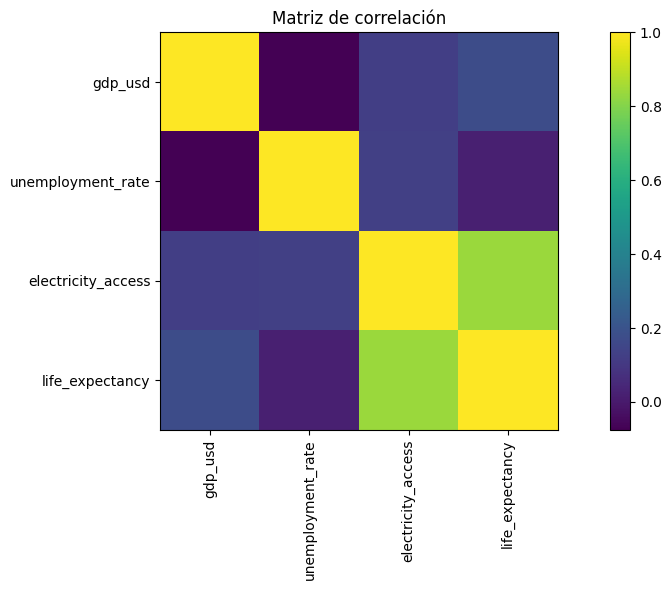

In [ ]:
# 
nums = [c for c in [col_gdp,"gdp_pc",col_unemp,col_elec,col_life] if c and c in df.columns]
nums = [c for c in nums if df[c].dtype.kind in "bfiu" and df[c].notna().any()]
if len(nums) >= 2:
    corr = df[nums].corr(numeric_only=True)
    plt.figure(figsize=(6+1.2*len(nums), 6))
    plt.imshow(corr, interpolation="nearest", cmap="Reds", vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(nums)), nums, rotation=90)
    plt.yticks(range(len(nums)), nums)
    plt.title("Matriz de correlacion")
    plt.tight_layout(); plt.show()
else:
    print("Variables numéricas insuficientes.")



## 10. Cierre: ¿Se confirman las hipótesis?
H0: Análisis univariante- PIB N y PIB Pc

# SON DISTINTOS

H1: Visualización por Regiones

# LAS REGIONES RICAS HAN CRECIDO, LAS POBRES TMBN PERO NO AL RITMO TAN ALTO COMO EL RESTO, POR LO QUE EL CRECIMIENTO ECONOMICO HA SIDO EN LOS OUTLAYER PAISES MAS RICOS

H2: Análisis Bivariante PIB Nominal vs PIB Per Cápita: ¿se correlacionan? 

# NO, EN TODAS, SU ALPHA ES MAYOR, QUE 0,05 CORRELACION NO SIEMPRE ES CAUSALIDAD

H3: Análisis multivariante: PIB N vs Resto de Vars Económicas: sino,¿que valores económicos si se correlacionan?

# NO, EN TODAS, SU ALPHA ES MAYOR, QUE 0,05 CORRELACION NO SIEMPRE ES CAUSALIDAD


## EXPERIMENTAL CON DEEP LEARNING (AYUDADO): PCA + k-means K=3

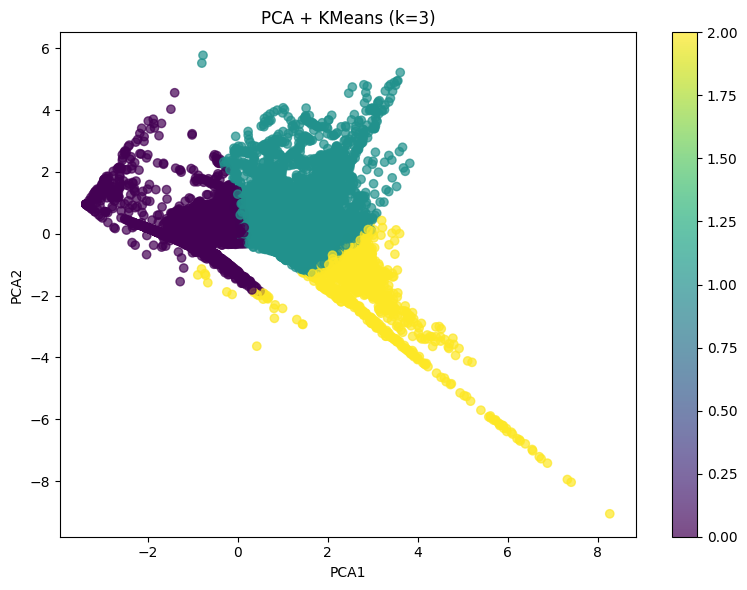

In [ ]:

try:  # Intenta ejecutar todo este bloque; si algo falla, saltará al except
    from sklearn.preprocessing import StandardScaler  # Para estandarizar (media 0, var 1)
    from sklearn.decomposition import PCA            # Para reducir dimensión (PCA)
    from sklearn.cluster import KMeans               # Para agrupar con k-means
    import matplotlib.pyplot as plt                  # Para graficar

    feats = [c for c in ["gdp_pc", col_unemp, col_elec, col_life] if c and c in df.columns]  # Selecciona columnas existentes y no vacías
    if len(feats) >= 2 and df[feats].notna().any().any():  # Comprueba que haya ≥2 variables y que no sean todas NaN
        X = df[feats].copy().fillna(0.0).values  # Toma los datos y rellena NaN con 0.0 (imputación simple)
        Xs = StandardScaler().fit_transform(X)   # Estandariza cada variable (crítico para PCA y k-means)
        Xp = PCA(n_components=2, random_state=42).fit_transform(Xs)  # Proyecta a 2 componentes para visualizar
        km = KMeans(n_clusters=3, n_init=10, random_state=42).fit(Xs)  # Ajusta k-means con 3 clústeres (10 reinicios)
        labels = km.labels_  # Obtiene la etiqueta de clúster (0,1,2) para cada fila

        plt.figure(figsize=(8,6))  # Crea figura de 8x6 pulgadas
        plt.scatter(
            Xp[:,0], Xp[:,1],         # Coordenadas en el plano PCA (PC1 vs PC2)
            c=labels,                 # Colorea cada punto por su clúster
            cmap="Reds",              # <<< Escala de rojos
            alpha=0.7,                # Transparencia para ver solapes
            edgecolors="none"         # Sin borde para puntos más limpios
        )
        plt.xlabel("PCA1")  # Etiqueta eje X
        plt.ylabel("PCA2")  # Etiqueta eje Y
        plt.title("PCA + KMeans (k=3)")  # Título del gráfico

        cbar = plt.colorbar()                 # Barra de color para interpretar la escala
        cbar.set_label("Cluster")             # Título de la barra
        cbar.set_ticks([0, 1, 2])             # Ticks alineados con etiquetas de k-means
        cbar.update_ticks()                   # Actualiza los ticks por si el backend lo requiere

        plt.tight_layout()  # Ajusta márgenes automáticamente
        plt.show()          # Muestra el gráfico
    else:
        print("PCA/KMeans omitidos: variables insuficientes o todas nulas.")  # Mensaje si faltan variables/datos
except Exception as e:
    print("PCA/KMeans saltados (instala scikit-learn o revisa columnas). Detalle:", e)  # Mensaje si ocurre algún error



Separación horizontal/vertical: muestra cómo los países se distribuyen según combinaciones de tus 2–4 indicadores.

Grupos de color: KMeans detecta 3 “tipos” de perfiles socioeconómicos similares entre sí en el espacio estandarizado.

No confundas: Los ejes no son “PIB pc” o “desempleo” puros; son mezclas. Para saber qué representa cada eje, mira las cargas (loadings) de la PCA.

Limitaciones:

Elegir k=3 es arbitrario; valida con silhouette, elbow o Calinski–Harabasz.

KMeans asume clusters “esféricos” y de varianza similar; si no se cumple, prueba GMM o DBSCAN.

Imputar con 0 puede empujar observaciones faltantes hacia un cluster artificial.

1) Qué vamos a comprobar (multivariante)

Correlación entre log(PIB) y log(PIB pc) en el último año.

Papel de la población como tercera variable:

Recuerda: PIB = PIB_pc × Población ⇒ en log: log(PIB) = log(PIB_pc) + log(Población).

Correlaciones de Pearson y Spearman (lineal vs. monótona).

Correlación parcial de log(PIB) con log(PIB_pc) controlando población.

Regresión OLS: log(PIB) ~ log(PIB_pc) + log(Población) para ver el peso relativo de cada factor.

Matriz de correlación y mapa (si quieres visualizar)

Qué ves en el gráfico
Cada punto es un país (o registro). Los colores (0,1,2) son los tres grupos que K-Means encontró según 2–4 variables: PIB per cápita, desempleo, acceso a electricidad y esperanza de vida.
Los ejes PCA1 y PCA2 no son variables originales: son combinaciones que resumen el patrón común de esas variables para poder dibujarlo en 2D.

Qué significan los ejes (interpretación típica con esas variables)

PCA1 ≈ “nivel de desarrollo”: suele aumentar cuando suben PIB pc, esperanza de vida y electrificación y disminuye si el desempleo es alto. A la derecha, países más “avanzados”; a la izquierda, menos.

PCA2 ≈ “segundo gradiente socio-laboral”: separa países con combinaciones distintas (p. ej., buena electrificación/vida pero desempleo alto, frente a menor desempleo pero peores servicios/PIB pc).

Qué significan los grupos (colores)

Cluster “2” (amarillo): países con alto PCA1 → típicamente alto PIB pc, altísima electrificación, mayor esperanza de vida y, en conjunto, perfil desarrollado.

Cluster “1” (verde/teal): intermedios/emergentes: valores medios en PIB pc y vida; electrificación amplia pero no plena; desempleo variable.

Cluster “0” (morado): bajo desarrollo relativo: PIB pc bajo, menor esperanza de vida, electrificación más limitada y/o desempleo que tira hacia abajo.

Cómo leerlo
Si un país está a la derecha (PCA1 alto) y en el cluster 2, su perfil socioeconómico es alto. Si está a la izquierda y en el cluster 0, es lo contrario. El cluster 1 ocupa la zona intermedia.

Avisos rápidos

Los IDs 0/1/2 son etiquetas arbitrarias (no “mejor/peor”).

Rellenar faltantes con 0 puede empujar algunos países a extremos; idealmente imputar con mediana.

Si quieres saber con certeza qué carga más en cada eje, mira las cargas del PCA (loadings); pero, con estas variables, la lectura anterior es la que suele salir.

In [ ]:
########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa

## ANEXO: CODIGOS RESPALDO Y MEJORA DE VISUALIZACIONES

In [ ]:
########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa

#1

In [ ]:
########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======= Config =======
CSV_PATH = ""  # <- Déjalo vacío si ya tienes df en memoria. Si no, pon aquí la ruta a tu CSV.
OUTDIR   = "./outputs_pib"

# Si conoces los nombres de columnas, puedes fijarlos aquí (sino se autodetectan):
COL_COUNTRY = None   # p.ej. "Country Name"
COL_YEAR    = None   # p.ej. "Year"
COL_GDP     = None   # p.ej. "GDP (current US$)" o "gdp_usd"

# ======= Utilidades =======
def guess_col(df, candidates_exact=set(), candidates_partial=()):
    cols = list(df.columns)
    low = {c: c.lower() for c in cols}
    for c in cols:
        if low[c] in candidates_exact:
            return c
    for c in cols:
        if any(p in low[c] for p in candidates_partial):
            return c
    return None

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def q(arr, p):
    return float(np.nanpercentile(arr, p))

def fmt_money(v):
    try:
        return f"${v:,.0f}"
    except Exception:
        return str(v)

# ======= Carga df =======
if "df" in globals() and isinstance(df, pd.DataFrame):
    print("Usando df ya cargado en memoria con forma:", df.shape)
elif CSV_PATH:
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"No se encontró el CSV en: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
    print(" Cargado df desde CSV con forma:", df.shape)
else:
    raise RuntimeError("No existe 'df' en memoria y CSV_PATH está vacío. Define CSV_PATH o crea df antes.")

# ======= Autodetección / fijación de columnas =======
if COL_YEAR is None:
    COL_YEAR = guess_col(
        df, candidates_exact={"year","año","anio","period","periodo"},
        candidates_partial=("year","año","anio","period","fecha")
    )
if COL_GDP is None:
    COL_GDP = guess_col(
        df, candidates_exact={"gdp","gdp_usd","pib","pib_usd","ngdp","gdp_current_usd","value"},
        candidates_partial=("gdp","pib","current","usd","ngdp","value")
    )
if COL_COUNTRY is None:
    COL_COUNTRY = guess_col(
        df, candidates_exact={"country","pais","país","economy","name","country_name","countryname"},
        candidates_partial=("country","pais","país","economy","name")
    )

print("Columnas detectadas/fijadas:")
print(" - País   :", COL_COUNTRY)
print(" - Año    :", COL_YEAR)
print(" - PIB    :", COL_GDP)

for col, label in [(COL_COUNTRY, "COL_COUNTRY"), (COL_YEAR, "COL_YEAR"), (COL_GDP, "COL_GDP")]:
    if col is None or col not in df.columns:
        raise ValueError(f"No pude detectar {label}. Revísalo y asígnalo manualmente.")

# ======= Limpieza y último año =======
df = df.copy()
df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors="coerce")
df[COL_GDP]  = pd.to_numeric(df[COL_GDP], errors="coerce")

latest = int(df[COL_YEAR].dropna().max())
dfl = df.loc[df[COL_YEAR] == latest].copy()
dfl = dfl.loc[(dfl[COL_GDP] > 0) & dfl[COL_COUNTRY].notna()].copy()

if dfl.empty:
    raise ValueError("No hay valores positivos de PIB para el último año tras limpieza.")

# ======= Métricas (log10 y USD) =======
x_log = np.log10(dfl[COL_GDP].values)
n = x_log.size

summary = {
    "Año": latest,
    "n_paises": int(n),
    "log10_media": float(np.nanmean(x_log)),
    "log10_mediana": float(np.nanmedian(x_log)),
    "log10_std": float(np.nanstd(x_log, ddof=1)) if n > 1 else float("nan"),
    "log10_min": float(np.nanmin(x_log)),
    "log10_p10": q(x_log, 10),
    "log10_p25": q(x_log, 25),
    "log10_p75": q(x_log, 75),
    "log10_p90": q(x_log, 90),
    "log10_max": float(np.nanmax(x_log)),
    "USD_media_geom": float(10 ** np.nanmean(x_log)),
    "USD_mediana": float(10 ** np.nanmedian(x_log)),
    "USD_p10": float(10 ** q(x_log, 10)),
    "USD_p25": float(10 ** q(x_log, 25)),
    "USD_p75": float(10 ** q(x_log, 75)),
    "USD_p90": float(10 ** q(x_log, 90)),
    "USD_min": float(10 ** np.nanmin(x_log)),
    "USD_max": float(10 ** np.nanmax(x_log)),
    "USD_media_arit": float(np.nanmean(dfl[COL_GDP])),
}
summary_df = pd.DataFrame([summary])

########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa



In [ ]:
# 2

In [ ]:
########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa
#Explicación
# Objetivo: mostrar una TABLA clara con el PIB TOTAL por región (último año),
#           junto con métricas útiles (porcentaje mundial, nº de países, media, mediana),
#           y guardar resultados en CSV y Excel. Incluye gráfico de barras con etiquetas.
#
# Requisitos: pip install pandas matplotlib requests openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata, re, io, zipfile, requests
from pathlib import Path

# -------------------------------
# 1) Cargar tu CSV
# -------------------------------
PATH = r"C:\Users\Asus Vivobook\Downloads\world_bank_dataset.csv.csv"
try:
    df = pd.read_csv(PATH)
except UnicodeDecodeError:
    df = pd.read_csv(PATH, encoding="latin-1")

# -------------------------------
# 2) Utilidades de normalización y detección flexible
# -------------------------------
#Explicación
def normalize(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^A-Za-z0-9]+", "", s).lower()
    return s

norm_cols = {normalize(c): c for c in df.columns}

#Explicación
# Detectar columnas clave (GDP, año, país, código)
def pick_col(candidates):
    for c in candidates:
        if c in norm_cols: 
            return norm_cols[c]
    return None

gdp_col   = pick_col(["gdpusd","pibusd","gdp","nygdpmktpcd","gdpcurrentusd","gdpcurrentus"])
year_col  = pick_col(["year","año","anio","ano","year"])
country_col = pick_col(["country","pais","país","tablename","shortname"])
ccode_col = pick_col(["countrycode","country_code","codigopais","códigopaís","code","iso3code","iso3"])
region_col= pick_col(["region","región"])

#Explicación
# Fallbacks por palabras clave
if gdp_col is None:
    for k, v in norm_cols.items():
        n = normalize(k)
        if ("gdp" in n or "pib" in n or "nygdpmktpcd" in n) and ("percapita" not in n and "pc" not in n):
            gdp_col = v; break
if year_col is None and "Year" in df.columns:
    year_col = "Year"

if gdp_col is None:
    raise KeyError("No se encontró la columna de PIB (USD). Revisa df.columns.")
df[gdp_col] = pd.to_numeric(df[gdp_col], errors="coerce")
if year_col:
    df[year_col] = pd.to_numeric(df[year_col], errors="coerce")

# -------------------------------
# 3) Incorporar Región (si no está) desde WDICountry.csv
# -------------------------------
#Explicación
if region_col is None:
    if ccode_col is None and "Country Code" in df.columns:
        ccode_col = "Country Code"
    # Descargar metadatos de países del Banco Mundial
    WDI_ZIP_URL = "https://databank.worldbank.org/data/download/WDI_CSV.zip"
    r = requests.get(WDI_ZIP_URL, timeout=120); r.raise_for_status()
    z = zipfile.ZipFile(io.BytesIO(r.content))
    cand = [n for n in z.namelist() if n.lower().endswith("wdicountry.csv")]
    if not cand:
        raise RuntimeError("No se encontró WDICountry.csv en el ZIP WDI.")
    meta = pd.read_csv(z.open(cand[0]), encoding="latin-1")

    # Detectar columnas en meta
    def pick_meta(cols, targets):
        m = {normalize(c): c for c in cols}
        for t in targets:
            if t in m: return m[t]
        return None

    meta_code   = pick_meta(meta.columns, ["countrycode","code","iso3code","iso3"])
    meta_region = pick_meta(meta.columns, ["region","región"])
    meta_name   = pick_meta(meta.columns, ["tablename","shortname","countryname","name"])
    if meta_region is None:
        raise RuntimeError(f"WDICountry.csv no trae 'Region'. Columnas: {list(meta.columns)}")

    # Merge por código si es posible; si no, por nombre (normalizado)
    if ccode_col and meta_code:
        df = df.merge(meta[[meta_code, meta_region]], left_on=ccode_col, right_on=meta_code, how="left")
        region_col = meta_region
    elif country_col and meta_name:
        df["_norm_country"]  = df[country_col].astype(str).apply(normalize)
        meta["_norm_country"] = meta[meta_name].astype(str).apply(normalize)
        df = df.merge(meta[["_norm_country", meta_region]], on="_norm_country", how="left")
        df.drop(columns=["_norm_country"], inplace=True)
        region_col = meta_region
    else:
        raise ValueError("No hay ISO3 ni nombre de país compatible para mapear región.")

# -------------------------------
# 4) Filtrar filas válidas y elegir último año
# -------------------------------
#Explicación
valid = df[region_col].notna() & (df[region_col] != "Aggregates")
dfv = df.loc[valid].copy()
if year_col and dfv[year_col].notna().any():
    latest_year = int(dfv[year_col].max())
    dfl = dfv[dfv[year_col] == latest_year].copy()
else:
    latest_year = None
    dfl = dfv.copy()

########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa

In [ ]:
# 3

In [ ]:
########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config opcional (fíjalas si la autodetección falla) ---
COL_COUNTRY = 'country'   # ya detectada arriba
COL_YEAR    = 'year'      # ya detectada arriba
COL_GDP     = 'gdp_usd'   # ya detectada arriba
COL_POP     = None        # por ejemplo: 'population', 'pop', 'SP.POP.TOTL'
COL_REGION  = None        # por ejemplo: 'region', 'Region', 'income_group'

def guess_col(df, candidates_exact=set(), candidates_partial=()):
    cols = list(df.columns)
    low = {c: c.lower() for c in cols}
    for c in cols:
        if low[c] in candidates_exact:
            return c
    for c in cols:
        if any(p in low[c] for p in candidates_partial):
            return c
    return None

# Autodetección población/región si no están fijadas
if COL_POP is None:
    COL_POP = guess_col(
        df,
        candidates_exact={'population','pop','sp.pop.totl'},
        candidates_partial=('population','pop','poblac','sp.pop')
    )
if COL_REGION is None:
    COL_REGION = guess_col(
        df,
        candidates_exact={'region','región','income_group','income level','area','zona'},
        candidates_partial=('region','región','income','ingreso','area','zona','grupo')
    )

print("Columnas para PIB pc:")
print(" - País   :", COL_COUNTRY)
print(" - Año    :", COL_YEAR)
print(" - PIB    :", COL_GDP)
print(" - Población:", COL_POP)
print(" - Región :", COL_REGION)

# Validaciones mínimas
assert COL_COUNTRY in df.columns and COL_YEAR in df.columns and COL_GDP in df.columns, "Faltan columnas básicas (country/year/gdp_usd)."
assert COL_POP is not None and COL_POP in df.columns, "No pude detectar columna de población. Fíjala en COL_POP."

# Limpieza y selección último año
df2 = df.copy()
df2[COL_YEAR] = pd.to_numeric(df2[COL_YEAR], errors='coerce')
df2[COL_GDP]  = pd.to_numeric(df2[COL_GDP], errors='coerce')
df2[COL_POP]  = pd.to_numeric(df2[COL_POP], errors='coerce')

latest = int(df2[COL_YEAR].dropna().max())
dfl = df2.loc[df2[COL_YEAR]==latest, [COL_COUNTRY, COL_GDP, COL_POP] + ([COL_REGION] if COL_REGION else [])].copy()

# Construcción de PIB pc: requiere PIB>0 y POP>0
dfl = dfl[(dfl[COL_GDP] > 0) & (dfl[COL_POP] > 0)].dropna(subset=[COL_GDP, COL_POP, COL_COUNTRY])
dfl['gdp_pc'] = dfl[COL_GDP] / dfl[COL_POP]

# Métricas univariantes (log10 y USD)
x_log = np.log10(dfl['gdp_pc'].values)
def q(a,p): return float(np.nanpercentile(a,p))
    # Retransformados a USD 
summary_pc = {
    "Año": latest,
    "n_paises": int(x_log.size),
    "log10_media": float(np.nanmean(x_log)),
    "log10_mediana": float(np.nanmedian(x_log)),
    "log10_std": float(np.nanstd(x_log, ddof=1)) if x_log.size>1 else float('nan'),
    "log10_min": float(np.nanmin(x_log)),
    "log10_p10": q(x_log,10),
    "log10_p25": q(x_log,25),
    "log10_p75": q(x_log,75),
    "log10_p90": q(x_log,90),
    "log10_max": float(np.nanmax(x_log)),

    "USD_media_geom": float(10**np.nanmean(x_log)),
    "USD_mediana": float(10**np.nanmedian(x_log)),
    "USD_p10": float(10**q(x_log,10)),
    "USD_p25": float(10**q(x_log,25)),
    "USD_p75": float(10**q(x_log,75)),
    "USD_p90": float(10**q(x_log,90)),
    "USD_min": float(10**np.nanmin(x_log)),
    "USD_max": float(10**np.nanmax(x_log)),
    "USD_media_arit": float(np.nanmean(dfl['gdp_pc']))
}
summary_pc_df = pd.DataFrame([summary_pc])

# Bandas y segmentos por log10(PIB pc)
bins   = [-np.inf, 2.5, 3, 3.5, 4, 4.5, 5, np.inf]  # ~ $316, $1k, $3.2k, $10k, $31.6k, $100k
labels = ["<2.5", "2.5–3", "3–3.5", "3.5–4", "4–4.5", "4.5–5", ">5"]
cats = pd.cut(x_log, bins=bins, labels=labels, include_lowest=True, right=True)
band_counts = pd.Series(cats).value_counts().reindex(labels, fill_value=0)
band_pct = (band_counts / band_counts.sum() * 100).round(2)
bandas_pc_df = pd.DataFrame({"Banda log10": labels, "Conteo": band_counts.values.astype(int), "Porcentaje(%)": band_pct.values})

segments = pd.cut(x_log, bins=[-np.inf, 3, 4, 4.5, np.inf],
                  labels=["Muy bajo (<$1k)", "Bajo–Medio ($1k–$10k)", "Medio–Alto ($10k–$31.6k)", "Alto (≥$31.6k)"])
seg_counts = pd.Series(segments).value_counts().reindex(["Muy bajo (<$1k)","Bajo–Medio ($1k–$10k)","Medio–Alto ($10k–$31.6k)","Alto (≥$31.6k)"], fill_value=0)
seg_pct = (seg_counts/seg_counts.sum()*100).round(2)
segmentos_pc_df = pd.DataFrame({"Segmento": seg_counts.index, "Conteo": seg_counts.values.astype(int), "Porcentaje(%)": seg_pct.values})

########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa

In [ ]:
#4

In [ ]:
########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# --- Detectar columnas clave que ya usamos ---
COL_COUNTRY = 'country' if 'country' in df.columns else None
COL_YEAR    = 'year'    if 'year'    in df.columns else None
COL_GDP     = 'gdp_usd' if 'gdp_usd' in df.columns else None

# Población (intenta detectar)
def guess_col(_df, exact=set(), partial=()):
    cols = list(_df.columns); low = {c:c.lower() for c in cols}
    for c in cols:
        if low[c] in exact: return c
    for c in cols:
        if any(p in low[c] for p in partial): return c
    return None

COL_POP = None
for cand in ['population','pop','SP.POP.TOTL']:
    if cand in df.columns:
        COL_POP = cand; break
if COL_POP is None:
    COL_POP = guess_col(df, {'population','pop','sp.pop.totl'}, ('population','poblac','pop','sp.pop'))

# Validaciones mínimas
assert COL_COUNTRY and COL_YEAR and COL_GDP, "Faltan columnas básicas (country/year/gdp_usd)."
assert 'gdp_pc' in df.columns, "Falta gdp_pc. Ejecuta antes el paso que crea PIB per cápita."
if COL_POP and COL_POP in df.columns:
    df[COL_POP] = pd.to_numeric(df[COL_POP], errors='coerce')

# Último año con datos válidos
latest = int(pd.to_numeric(df[COL_YEAR], errors='coerce').dropna().max())
dfl = df[df[COL_YEAR]==latest].copy()

# Mantener positivos (para log) y limpiar
for c in [COL_GDP, 'gdp_pc', COL_POP] if COL_POP else [COL_GDP, 'gdp_pc']:
    dfl[c] = pd.to_numeric(dfl[c], errors='coerce')

mask = (dfl[COL_GDP] > 0) & (dfl['gdp_pc'] > 0)
if COL_POP and COL_POP in dfl.columns:
    mask = mask & (dfl[COL_POP] > 0)

dfl = dfl.loc[mask, [COL_COUNTRY, COL_GDP, 'gdp_pc'] + ([COL_POP] if COL_POP else [])].dropna()

# 


########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa

In [ ]:
########################################################################################################################AAAAAAAAAAAAAAAAAAAAAAAAAAAAaaaaaaaaaaaaaaa